# Assignment 5. EDP-2023

### Team members:

Zakhar Yagudin, Skoltech, 2023 <br>
CRediT author statement: Coding, Writing - review

Khasan Akhmadiev, Skoltech, 2023 <br>
CRediT author statement: Coding, Writing - review & editing

Konstantin Zamansky, Skoltech, 2023 <br>
CRediT author statement: Supervision

https://beta.elsevier.com/researcher/author/policies-and-guidelines/credit-author-statement?trial=true

### Import Libraries

In [8]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import Image
from sklearn.preprocessing import minmax_scale

pd.options.plotting.backend = 'plotly'

### Present the system at state space with only measurements of coordinate $x_{i}$

In [9]:
def state_equation(sample_size: int = 200, X1: float = 5, V1: float = 1, T: float = 1, variance: float = 0.04):
    # Initialize values
    a = np.random.normal(0, np.sqrt(variance), sample_size)
    X_vector = np.array([np.zeros(sample_size)] * 2)
    X_vector[:, 0] = np.array([X1, V1])

    # Input matrix
    G = np.array([(T**2) / 2, T])
    # Transition matrix
    F = np.array([[1, T], [0, 1]])
    
    # calculate state equation
    for i in range(1, sample_size):
        X_vector[:, i] = F.dot(X_vector[:, i-1]) + G * a[i]
    
    return X_vector

def measurement_equation(X: np.array, meas_variance: float = 400):
    noise = np.random.normal(0, np.sqrt(meas_variance), int(X.shape[1]))
    # Observation matrix
    H = np.array([1, 0]).T

    # Initialize measurement values
    Z = np.array(np.zeros(int(X.shape[1])))

    # Calculate measurements
    for i in range(int(X.shape[1])):
        Z[i] = H.dot(X[:, i]) + noise[i]
        
    return Z

### Kalman Filter Algorithm

In [10]:
def Kalman_filter(Z: np.array, K_determined: float = 0, underestim_value: float = 1, sample_size: int = 200, T: int = 1, R: int = 400, variance: float = 0.04, m: int = 7, P0_0_diag: float = 10000):
    # Input matrix
    G = np.array([(T**2) / 2, T])
    # Transition matrix
    F = np.array([[1, T], [0, 1]])
    # Observation matrix
    H = np.array([1, 0]).T
    # Covariance matrix of state noise
    Q = G.dot(G.T) * variance

    # Initial zeros values
    X_filtered = np.array([np.zeros(sample_size)] * 2)
    X_extrapol = np.array([np.zeros(sample_size)] * 2)

    # Initial filtered estimate
    X_filtered[:, 0] = np.array([2, 0])
    X_extrapol[:, 0] = np.array([2, 0])

    # Initial filtration error covariance matrix
    P0 = np.array([[P0_0_diag, 0], [0, P0_0_diag]]) 

    # Diagonal elements of filtration error covariance matrix
    P_diag = np.array([np.zeros(sample_size)] * 2)
    P_diag[:, 0] = np.sqrt(np.diag(P0))

    # Initial Filter gain K
    K_gain = np.array([np.zeros(sample_size)] * 2)

    if K_determined == 0:
        # Implement Kalman update equations, Extrapolation m = 1
        for i in range(1, sample_size):
            X_pred = F.dot(X_filtered[:, i-1])
            P_pred = np.dot(F.dot(P0), F.T) + Q
            K = np.dot(P_pred, H.T) * 1 / (np.dot(H.dot(P_pred), H.T) + R)
            X_filtered[:, i] = X_pred + K @ (Z[i] - H @ X_pred)
            P0 = P_pred - np.dot(np.dot(K, H), P_pred)
            
            K_gain[:, i] = K
            P_diag[:, i] = np.sqrt(np.diag(P_pred))

        # Implement Kalman update equations, Extrapolation m = 7
        for i in range(1, sample_size):
            X_pred = np.dot(X_filtered[:, i], F ** (m-1))
            P_pred = np.dot(F.dot(P0), F.T) + Q
            K = np.dot(P_pred, H.T) * 1 / (np.dot(H.dot(P_pred), H.T) + R)
            X_extrapol[:, i] = X_pred + K * (Z[i] - H.dot(X_pred))
            P0 = P_pred - np.dot(np.dot(K, H), P_pred)
    
    else:
        # Implement Kalman update equations, Extrapolation m = 1
        for i in range(1, sample_size):
            X_pred = F.dot(X_filtered[:, i-1])
            P_pred = np.dot(F.dot(P0), F.T) + Q
            K = K_determined / underestim_value
            X_filtered[:, i] = X_pred + K * (Z[i] - H.dot(X_pred))
            P0 = P_pred - np.dot(np.dot(K, H), P_pred)

            K_gain[:, i] = np.array([K, K])
            P_diag[:, i] = np.sqrt(np.diag(P_pred))

        # Implement Kalman update equations, Extrapolation m = 7
        for i in range(1, sample_size):
            X_pred = F.dot(X_filtered[:, i-1])
            P_pred = np.dot(F.dot(P0), F.T) + Q
            K = K_determined / underestim_value
            X_extrapol[:, i] = X_pred + K * (Z[i] - H.dot(X_pred))
            P0 = P_pred - np.dot(np.dot(K, H), P_pred)
               
    return X_filtered, K_gain, P_diag, X_extrapol

In [11]:
X_vector = state_equation(sample_size = 200, X1 = 5, V1 = 1, T = 1, variance = 0.2**2)
Z = measurement_equation(X=X_vector, meas_variance = 20**2)

X_filtered, K_gain, P_diag, X_extrapol = Kalman_filter(Z=Z, K_determined=0, underestim_value=1, sample_size=200, T=1, R=400, variance=0.04, m=7, P0_0_diag=10000)

### Figure 1. True trajectory, measurements and filtered estimates

In [13]:
fig = go.Figure()

sample_size = 200
x = np.arange(sample_size)

y_state_vec = X_vector[0, :]
y_meas = Z
y_kalman_filter = X_filtered[0, :]

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_state_vec, name = 'True trajectory', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = y_meas, name = 'Measurements', 
                         marker_color = colors[2], mode= 'markers', marker_size = 5))

fig.add_trace(go.Scatter(x = x, y = y_kalman_filter, 
                         name = 'Filtered estimates', 
                         line_color = colors[1]))

fig.update_layout(template = 'simple_white', 
                  title = 'Estimation results using Kalman filter',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>Object's X position</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

In [14]:
fig.write_image(f"Estimation results using Kalman filter.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

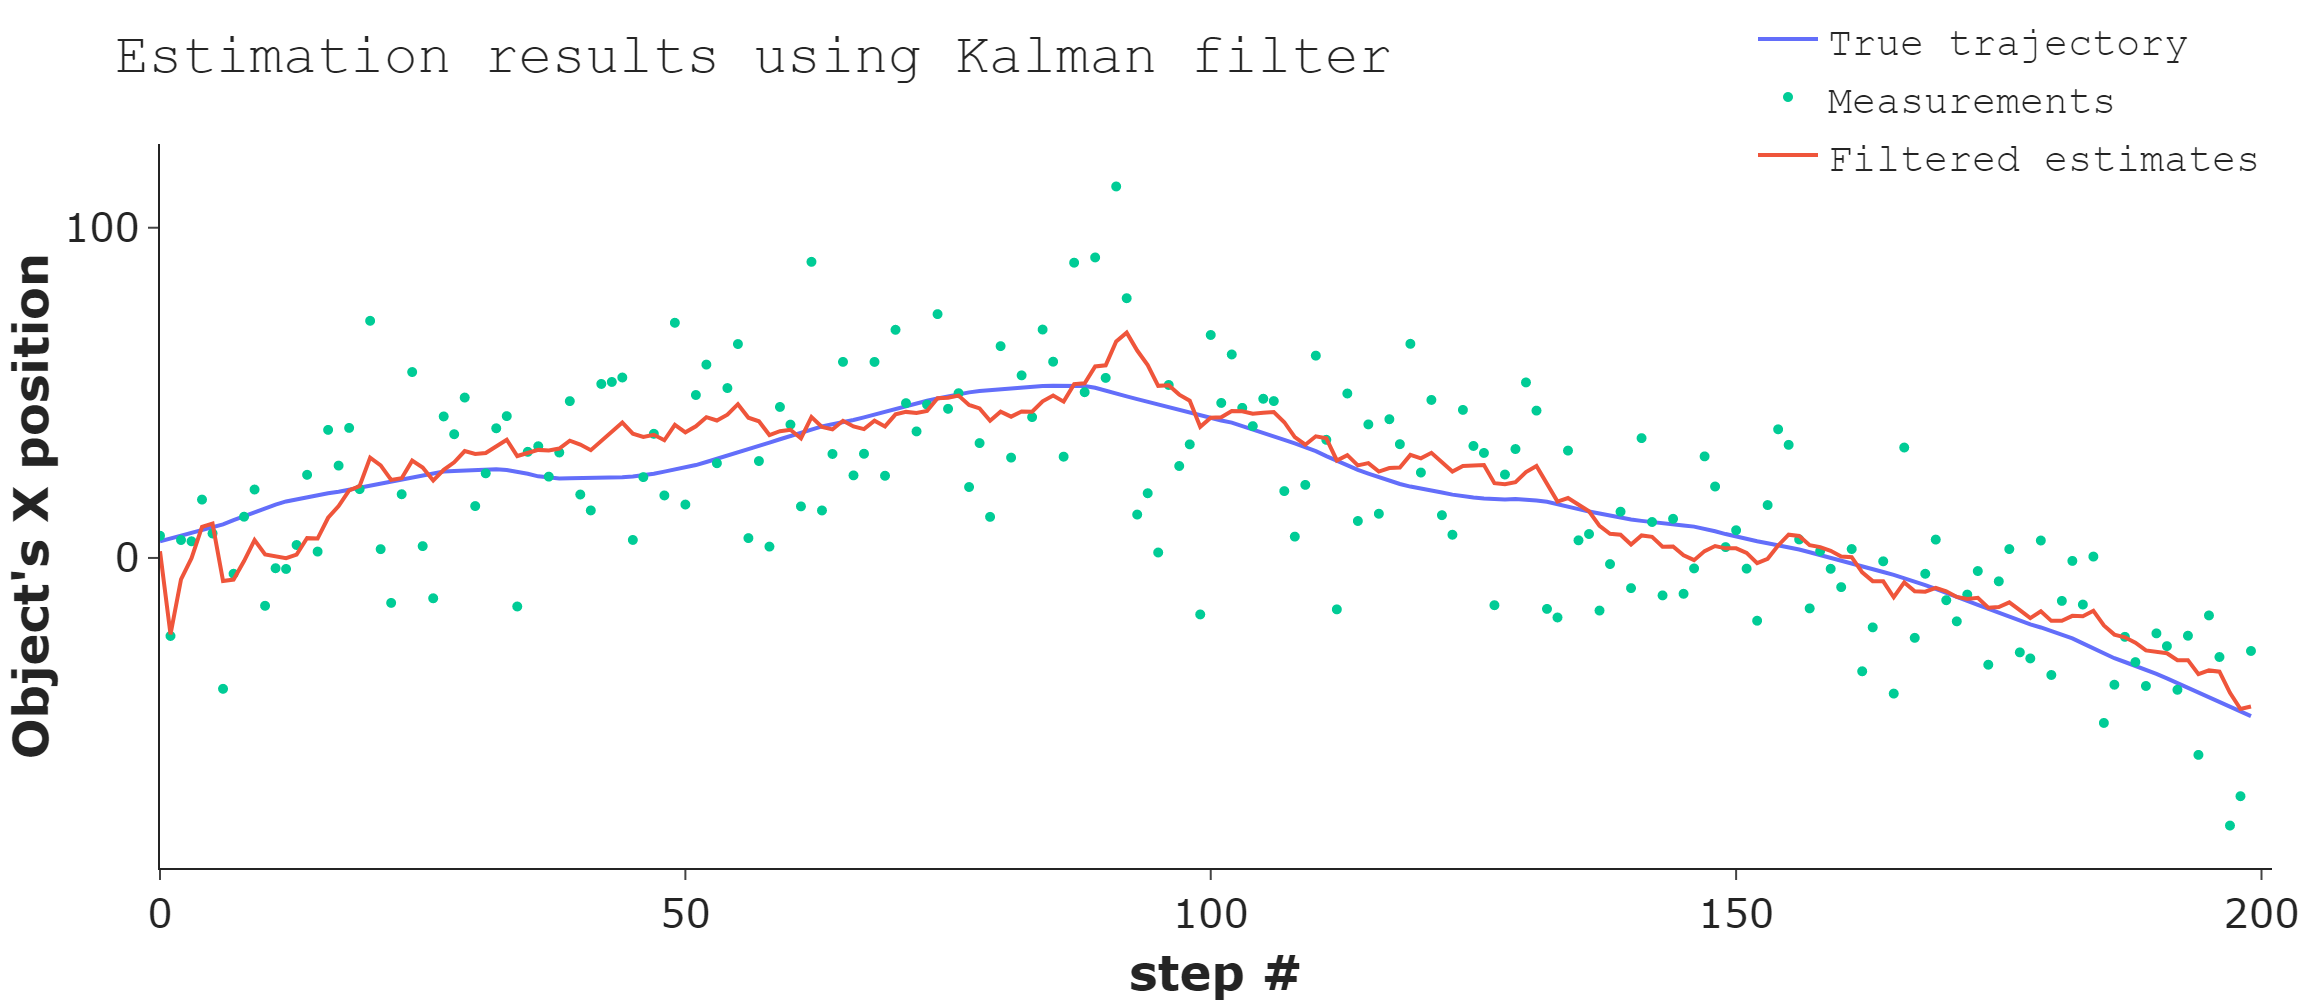

In [15]:
Image(f"Estimation results using Kalman filter.png")

### Figure 2. Filter gain K over the whole filtration interval

In [64]:
fig = go.Figure()

sample_size = 200
x = np.arange(sample_size)
y_filter_gain_x = K_gain[0, :]
y_filter_gain_v = K_gain[1, :]

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_filter_gain_x, name = 'Filter gain of coordinate x<sub>i</sub>', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = y_filter_gain_v, name = 'Filter gain of velocity V<sub>i</sub>', 
                         line_color = colors[2]))

fig.update_layout(template = 'simple_white', 
                  title = 'Filter gain K for state vector X',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>Filter gain K</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

In [65]:
fig.write_image(f"Filter gain K for state vector X.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

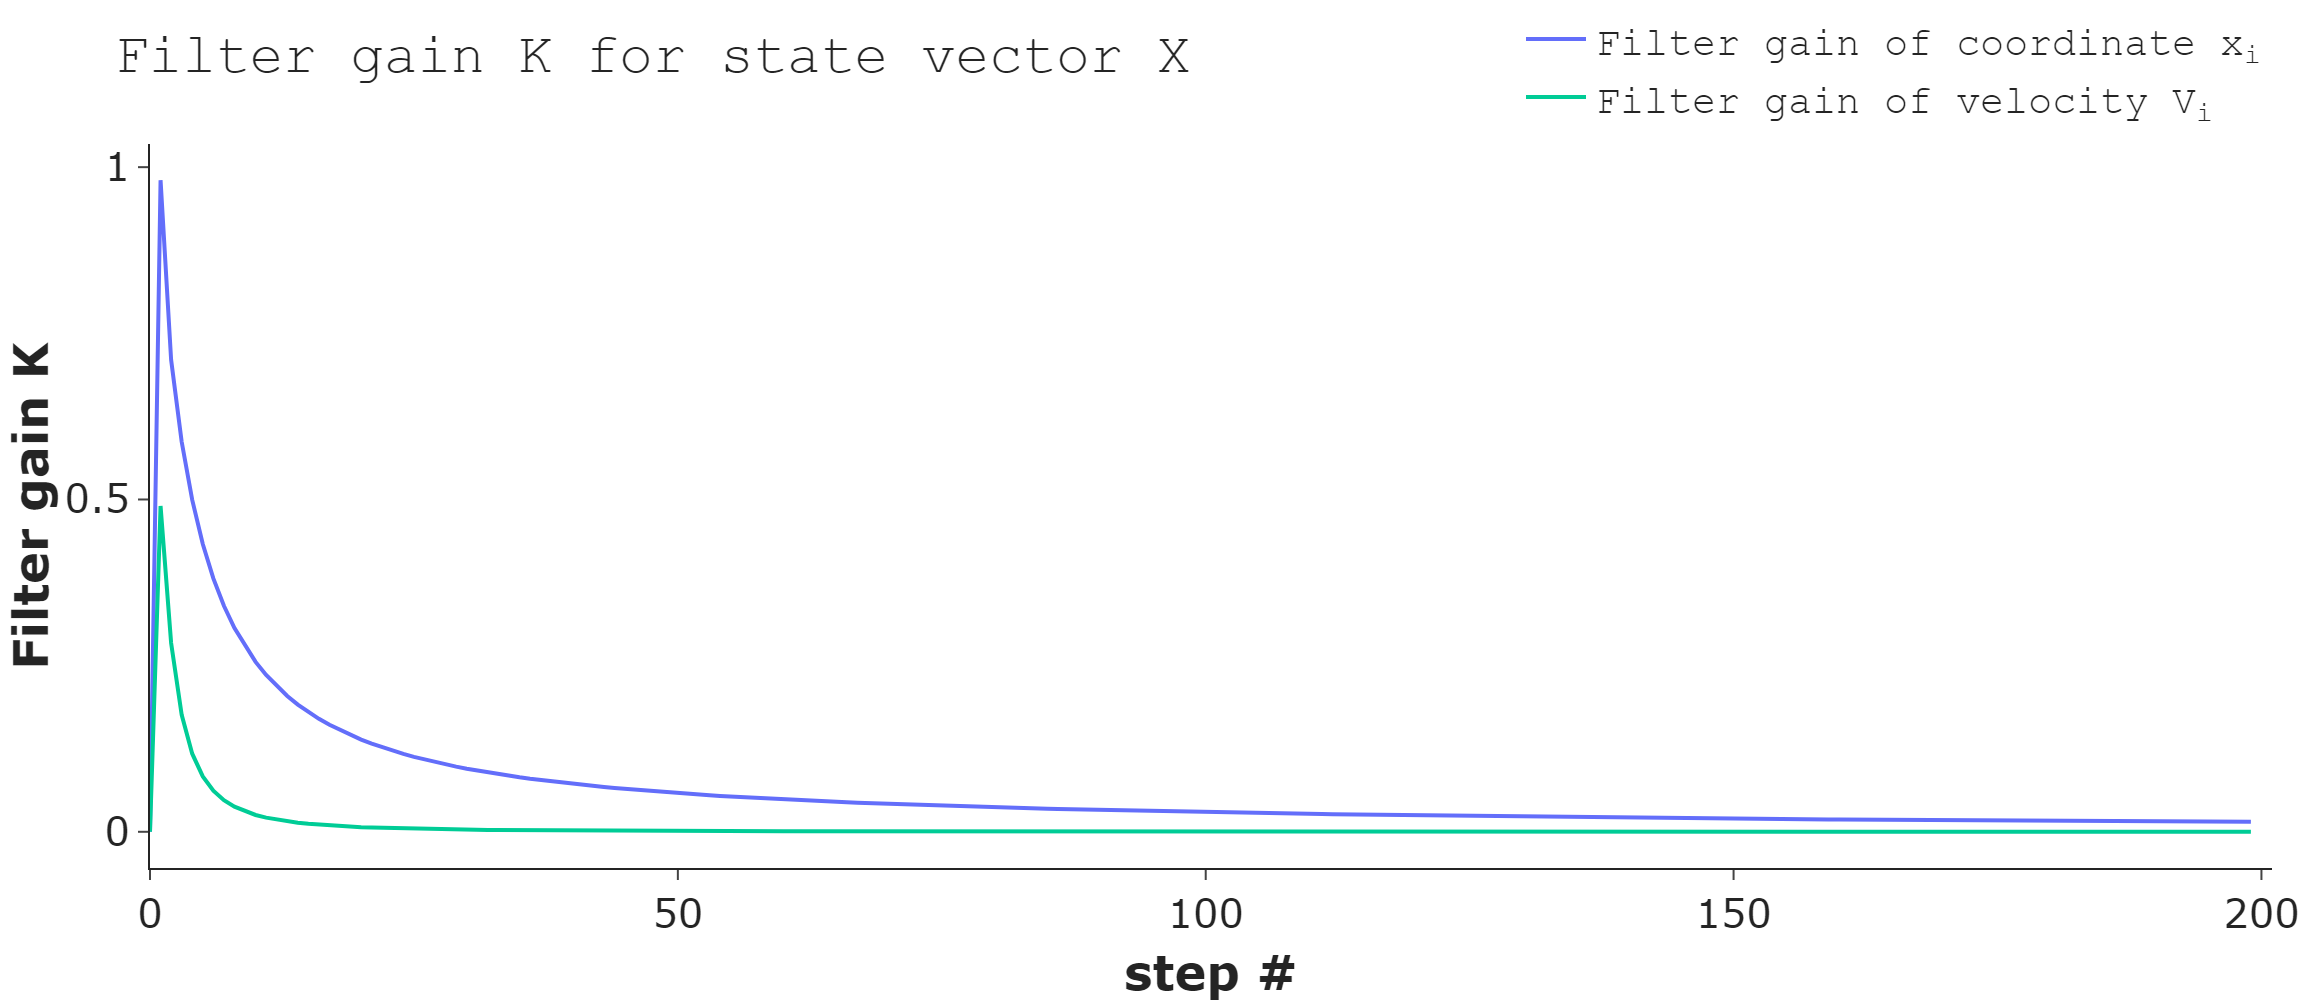

In [66]:
Image(f"Filter gain K for state vector X.png")

Filter gain K for state vector X quickly comes to stabilized state approximately after 30 steps. By the way, filter gain of velocity is stabilized faster than for coordinate.

### Figure 3. Standard deviation of estimation error of coordinate $x_{i}$

In [70]:
fig = go.Figure()

sample_size = 200
x = np.arange(sample_size)
y_cov_diag = P_diag[0, :]

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_cov_diag, name = 'True trajectory', 
                         line_color = colors[0]))

fig.update_layout(template = 'simple_white', 
                  title = 'Standard deviation of estimation error of coordinate x<sub>i</sub>',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>\u03c3</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

In [71]:
fig.write_image(f"Standard deviation of estimation error of coordinate.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

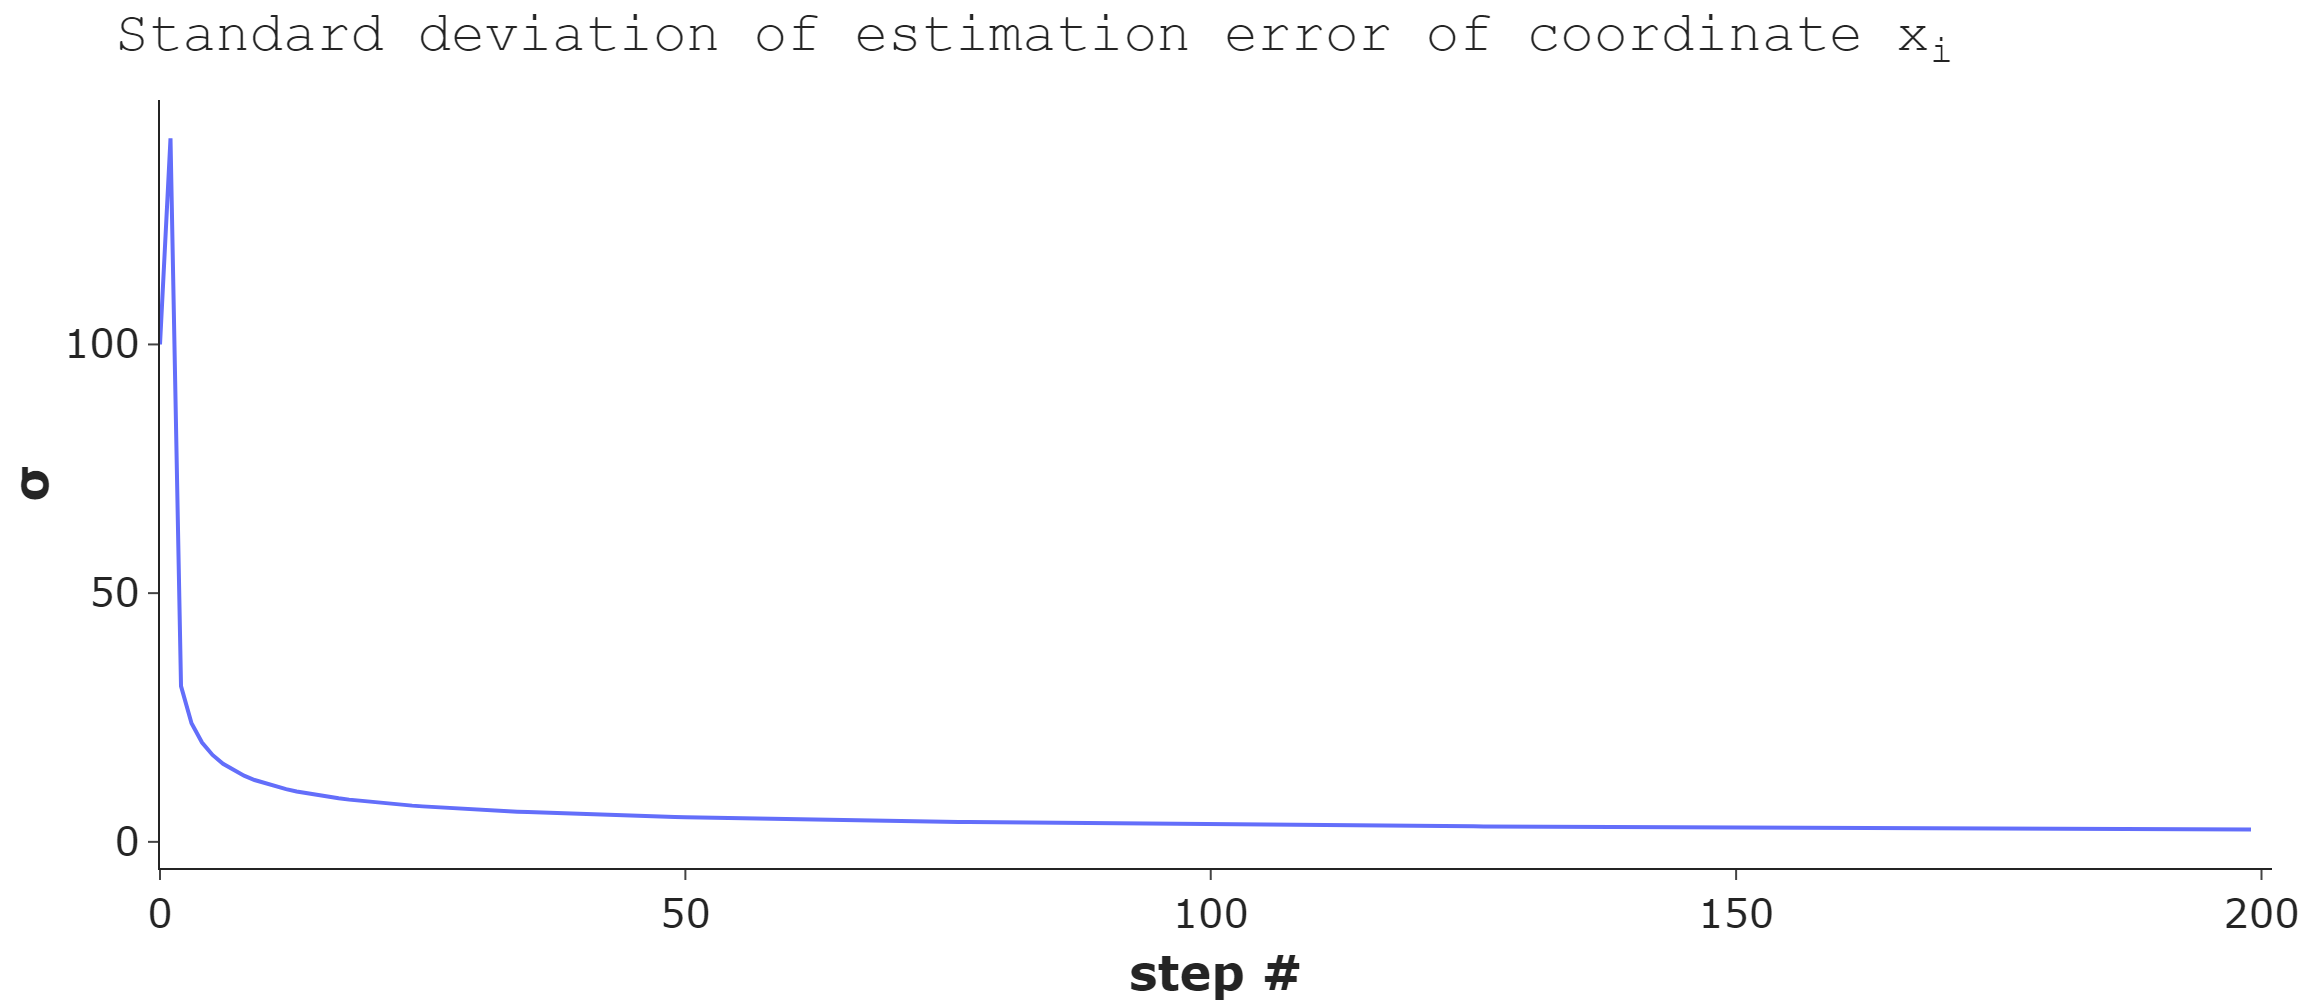

In [72]:
Image(f"Standard deviation of estimation error of coordinate.png")

It is verified that whether filter gain K and filtration error covariance matrix become constant very quickly approximately after 20 steps. It means that in conditions of a trajectory disturbed by random noise we cannot
estimate more than established limit of accuracy due to uncertainty.

### Figure 4. Increased extrapolation (m = 7) based on filtered estimates

In [22]:
fig = go.Figure()

sample_size = 200
x = np.arange(sample_size)
y_state_vec = X_vector[0, :]
y_meas = Z
y_kalman_filter = X_filtered[0, :]
y_extrapol = X_extrapol[0, :]

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_state_vec, name = 'True trajectory', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = y_meas, name = 'Measurements', 
                         marker_color = colors[2], mode= 'markers', marker_size = 5))

fig.add_trace(go.Scatter(x = x, y = y_kalman_filter, 
                         name = 'Filtered estimates (FE)', 
                         line_color = colors[1]))

fig.add_trace(go.Scatter(x = x, y = y_extrapol, 
                         name = 'FE with extrapolation = 7', 
                         line_color = colors[5]))

fig.update_layout(template = 'simple_white', 
                  title = 'Implementation of Kalman filter <br>with extrapolation',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>Object's X position</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

In [23]:
fig.write_image(f"Implementation of Kalman filter with extrapolation.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

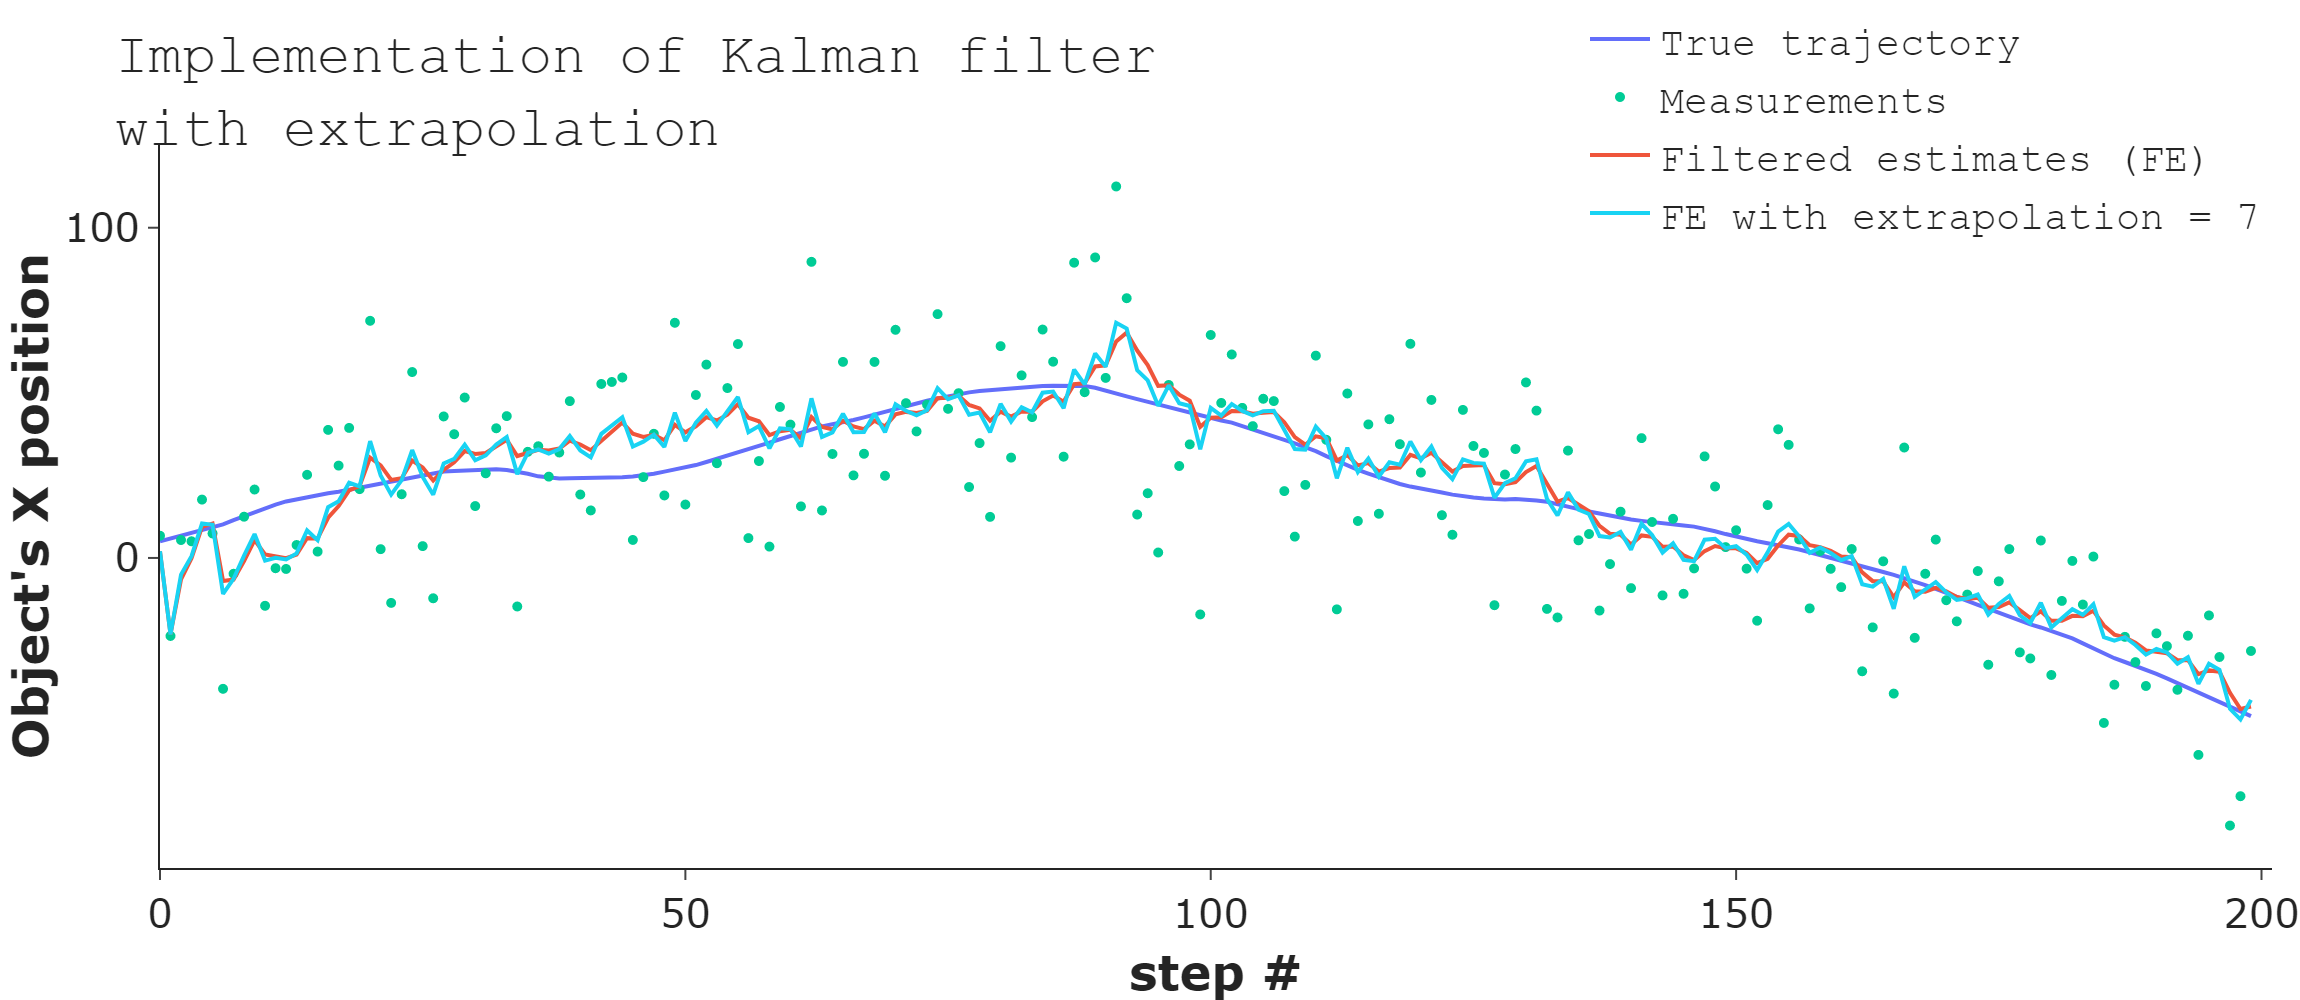

In [24]:
Image(f"Implementation of Kalman filter with extrapolation.png")

### Mean squared error calculation for filtered estimates of coordinate $x_{i,i}$ and its extrapolation (m steps)

In [25]:
def final_error(P0_0_diag, state_variance, Q_variance, X1, V1, K_determined, underestim_value, sample_size: int = 200, M: int = 500):
    #Initialization of matrices
    Error_true_filtered = np.zeros((2, sample_size))
    Error_true_extrapol = np.zeros((2, sample_size))
    K_gain_sum = np.zeros((2, sample_size))
    P_diag_sum = np.zeros((2, sample_size))

    for i in range(M):
        # State vector and Kalman filter calculation
        X_vector = state_equation(sample_size=sample_size, X1=X1, V1=V1, T = 1, variance=state_variance)
        Z = measurement_equation(X=X_vector, meas_variance=20**2)
        X_filtered, K_gain, P_diag, X_extrapol = Kalman_filter(Z=Z, K_determined=K_determined, underestim_value=underestim_value, sample_size=sample_size, T=1, R=400, variance=Q_variance, m=7, P0_0_diag=P0_0_diag)
        # Error calculation
        Error_true_filtered += (X_vector - X_filtered) ** 2
        Error_true_extrapol += (X_vector - X_extrapol) ** 2
        # Sum of filter gain K and diagonal elements of covariance matrix P
        K_gain_sum += K_gain
        P_diag_sum += P_diag

    #Final error calculation over M runs
    RMSE_true_filtered = np.sqrt(Error_true_filtered / (M - 1))
    RMSE_true_extrapol = np.sqrt(Error_true_extrapol / (M - 1))
    
    #Final mean calculation over M runs
    K_gain_mean = K_gain_sum / M
    P_diag_mean = P_diag_sum / M

    return RMSE_true_filtered, RMSE_true_extrapol, K_gain_mean, P_diag_mean

In [26]:
RMSE_true_filtered, RMSE_true_extrapol, K_gain_mean, P_diag_mean = final_error(M=500, P0_0_diag=10000, state_variance=0.04, Q_variance=0.04, X1=5, V1=1, K_determined=0, underestim_value=1, sample_size=200)

### Figure 5. Dynamics estimation of errors for filtered and extrapolated estimates

In [73]:
fig = go.Figure()

sample_size = 200
x = np.arange(sample_size)
y_RMSE_true_filtered = RMSE_true_filtered[0, :]
y_RMSE_true_extrapol = RMSE_true_extrapol[0, :]

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_filtered, name = 'RMSE of FE with m=1', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_extrapol, name = 'RMSE of FE with m=7', 
                         line_color = colors[4]))

fig.update_layout(template = 'simple_white', 
                  title = 'Dynamics of errors for estimated coordinates x<sub>i</sub>',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>\u03c3</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

In [74]:
fig.write_image(f"Dynamics of errors for estimated coordinates.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

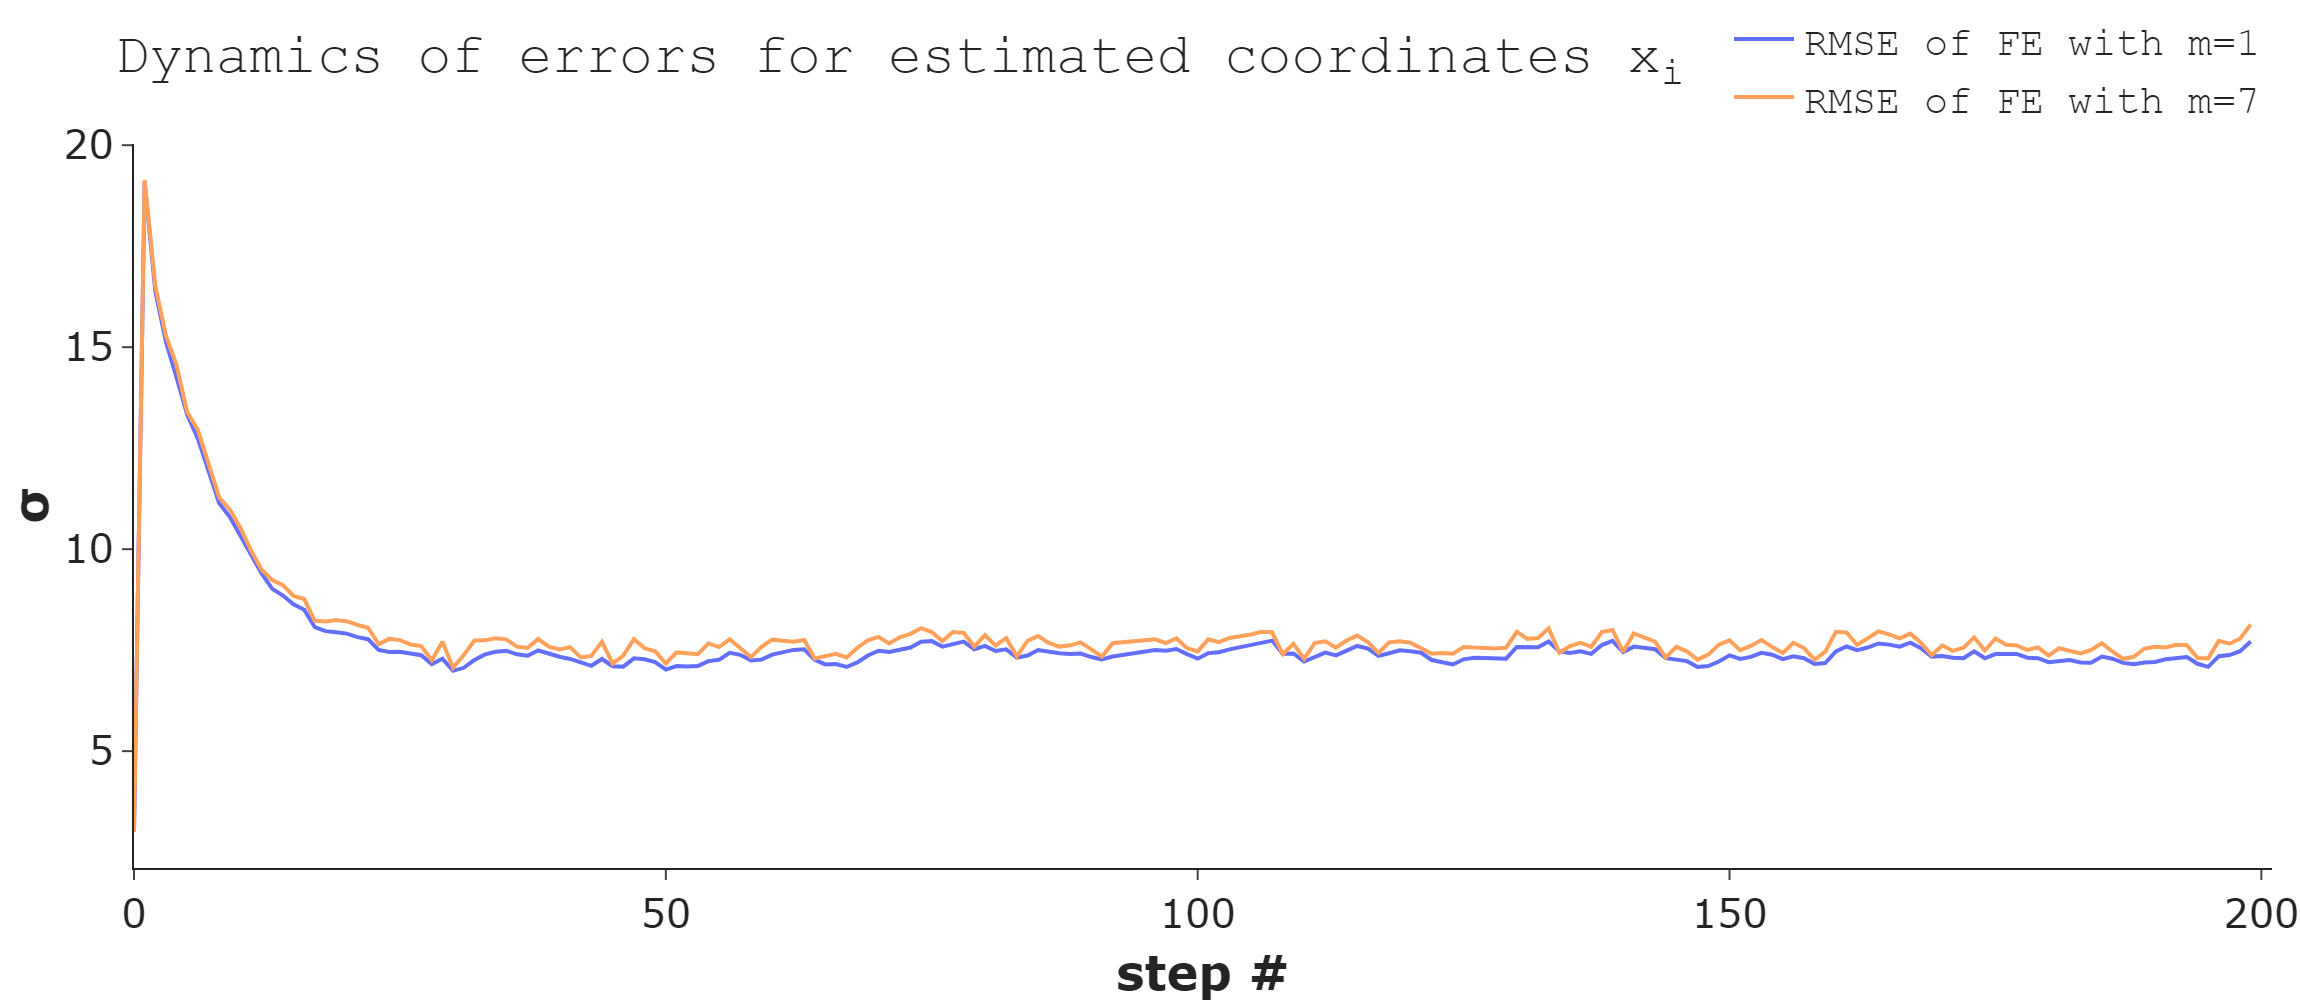

In [75]:
Image(f"Dynamics of errors for estimated coordinates.png")

Errors of filtered and extrapolated estimates becomes almost constant after 25 steps and estimation accuracy does not increase anymore.

### Figure 6. Comparison of filtered estimate error with standard deviation of measurements error

In [80]:
fig = go.Figure()

sample_size = 200
x = np.arange(sample_size)
y_RMSE_true_filtered = RMSE_true_filtered[0, :]
y_diag_mean = np.ones(sample_size) * 20

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_filtered, name = 'RMSE of filtered estimates', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = y_diag_mean, name = 'Std of measurements error', 
                         line_color = colors[2]))

fig.update_layout(template = 'simple_white', 
                  title = 'Comparison of filtered estimate error <br>with standard deviation of measurements error',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>\u03c3</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

In [81]:
fig.write_image(f"Comparison of filtered estimate error with standard deviation of measurements error.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

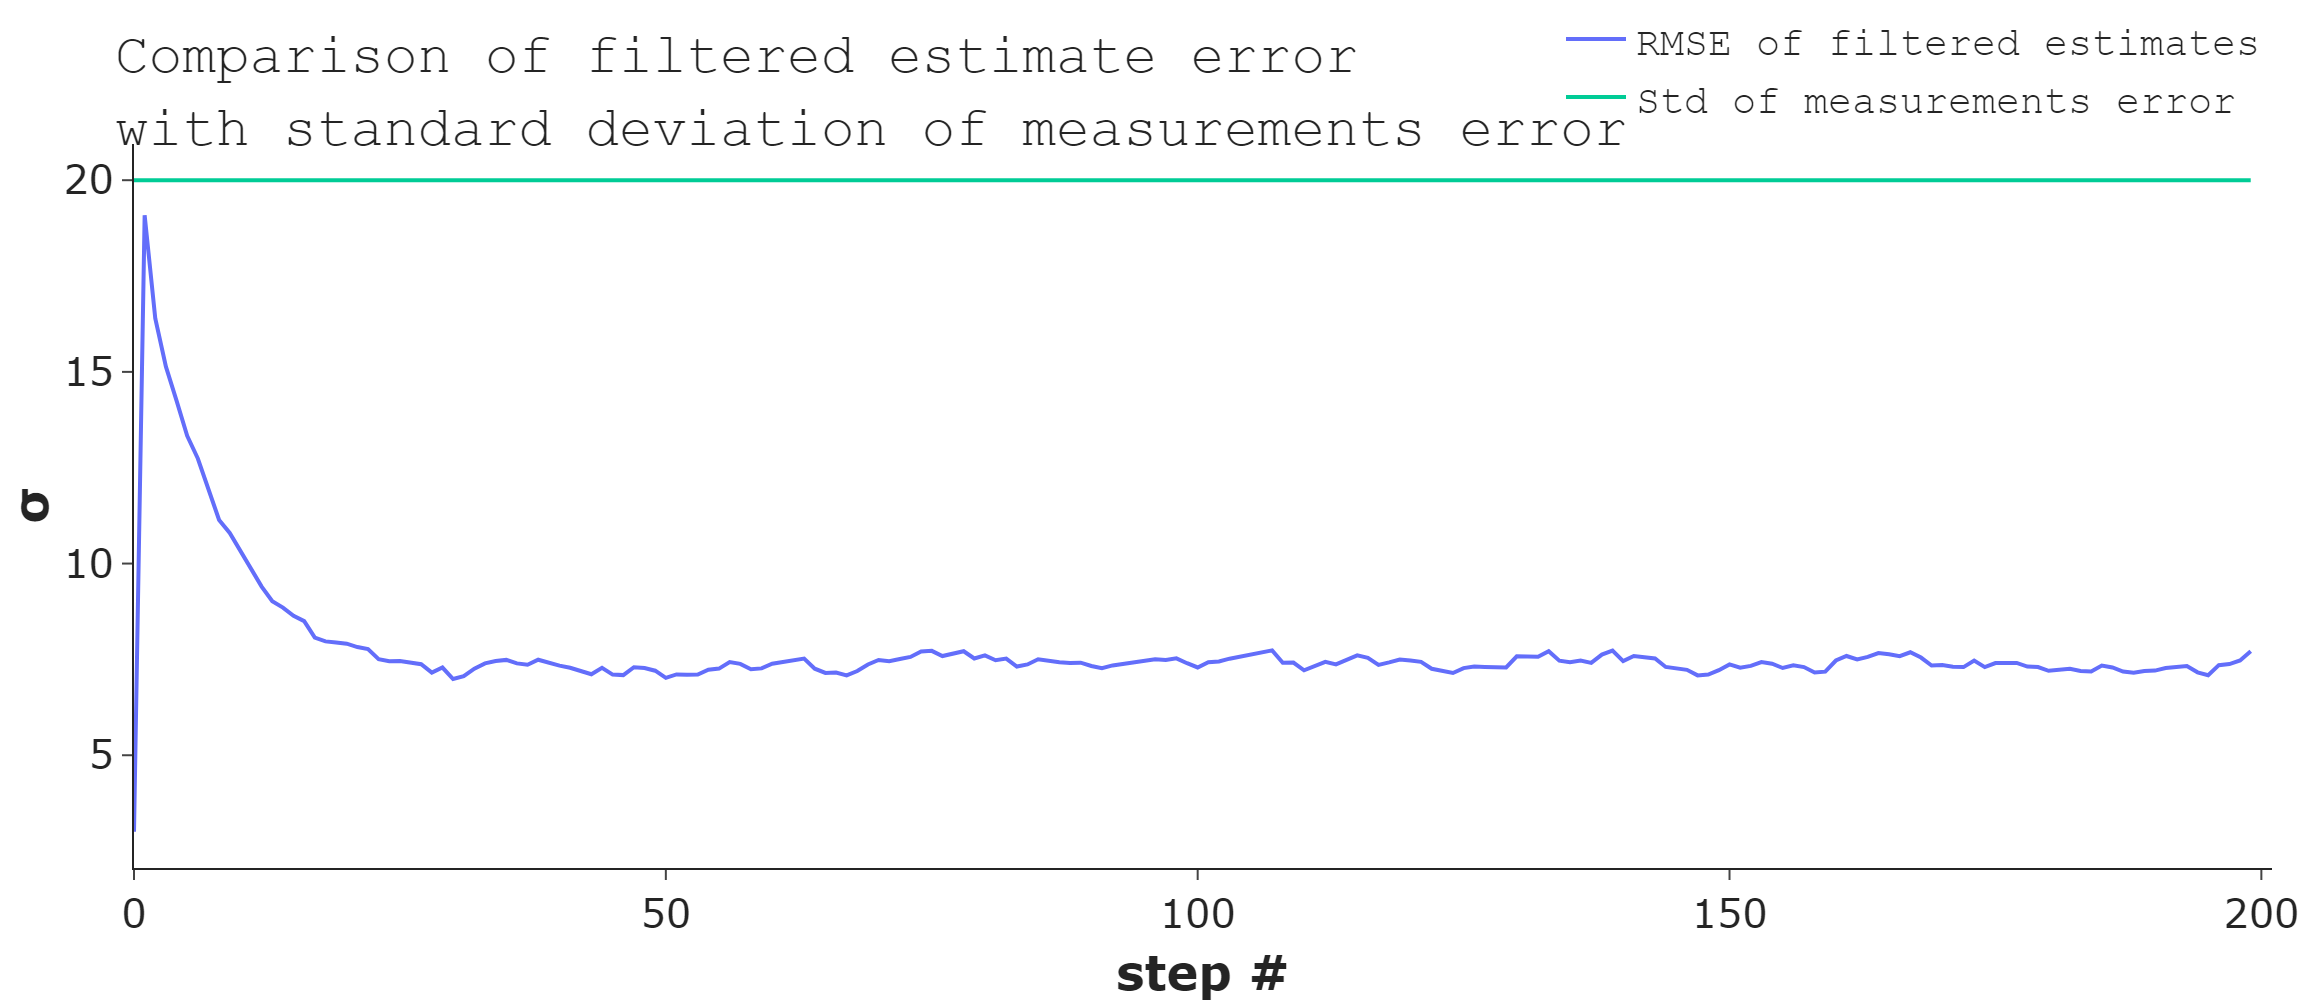

In [82]:
Image(f"Comparison of filtered estimate error with standard deviation of measurements error.png")

As is shown in Figure 6, Errors between filtered estimates and true trajectory are less three times than standard deviation of measurements errors. It means that Kalman filter effectively estimates true trajectory with lower errors than measurements.

### Figure 7. Comparison of estimation errors for initial errors of covariance matrix $P_{0, 0}$ = 10000 and $P_{0, 0}$ = 100

Mean squared error for $P_{0, 0}$ = 100

In [33]:
RMSE_true_filtered_100, RMSE_true_extrapol_100, K_gain_mean_100, P_diag_mean_100 = final_error(M=500, P0_0_diag=100, state_variance=0.04, Q_variance=0.04, X1=5, V1=1, K_determined=0, underestim_value=1, sample_size=200)

In [79]:
fig = go.Figure()

sample_size = 200
x = np.arange(sample_size)
y_RMSE_true_filtered = RMSE_true_filtered[0, :]
y_RMSE_true_filtered_100 = RMSE_true_filtered_100[0, :]

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_filtered, name = 'RMSE P<sub>0,0</sub> = 10000', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_filtered_100, name = 'RMSE P<sub>0,0</sub> = 100', 
                         line_color = colors[4]))

fig.update_layout(template = 'simple_white', 
                  title = 'Comparison of estimation errors <br>for both variants of P<sub>0,0</sub>',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>\u03c3</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

In [83]:
fig.write_image(f"Comparison of estimation errors for both variants of P.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

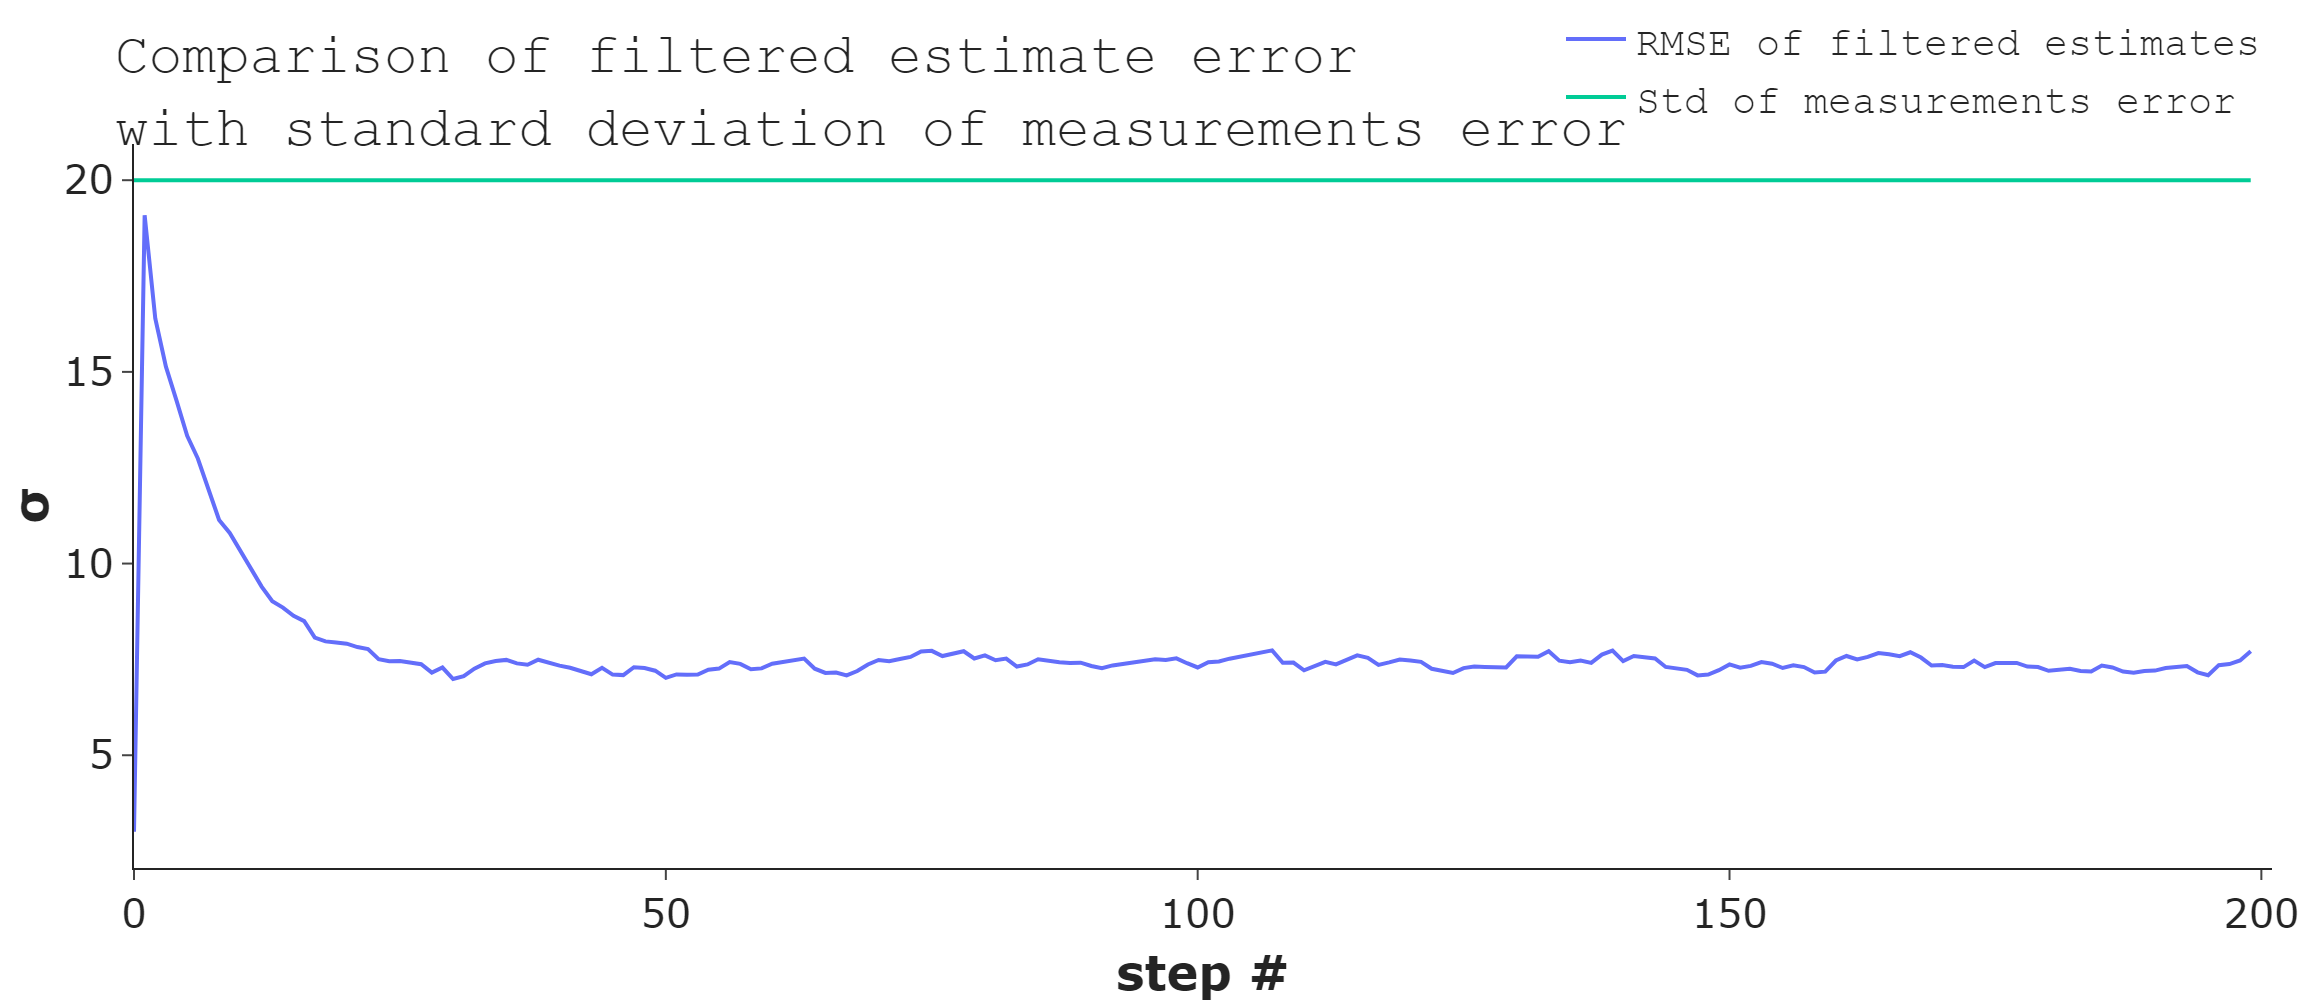

In [84]:
Image(f"Comparison of estimation errors for both variants of P.png")

As it is seen in Figure 7, accuracy of initial conditions $P_{0,0}$ does not affect on estimation errors of Kalman filter and these errors become constant after approximately the same steps (> 30 steps). It means that in conditions, when the sample size consist of huge number of points, initial filtration error does not influent on the accuracy of Kalman filter. In case, when sample size is small, the choice of initial errors plays important role in accuracy of the filter. 

### Figure 8. Comparison of calculation errors with true estimation errors

In [85]:
fig = go.Figure()

sample_size = 200
x = np.arange(sample_size)
y_RMSE_true_filtered = RMSE_true_filtered[0, :]
y_diag_mean = P_diag_mean[0, :]

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_filtered, 
                         name = 'RMSE of filtered estimates', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = y_diag_mean, 
                         name = 'Estimation error', 
                         line_color = colors[4]))

fig.update_layout(template = 'simple_white', 
                  title = 'Comparison of calculation errors P<sub>i,i</sub> <br>with true estimation errors',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>\u03c3</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

In [86]:
fig.write_image(f"Comparison of calculation errors with true estimation errors.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

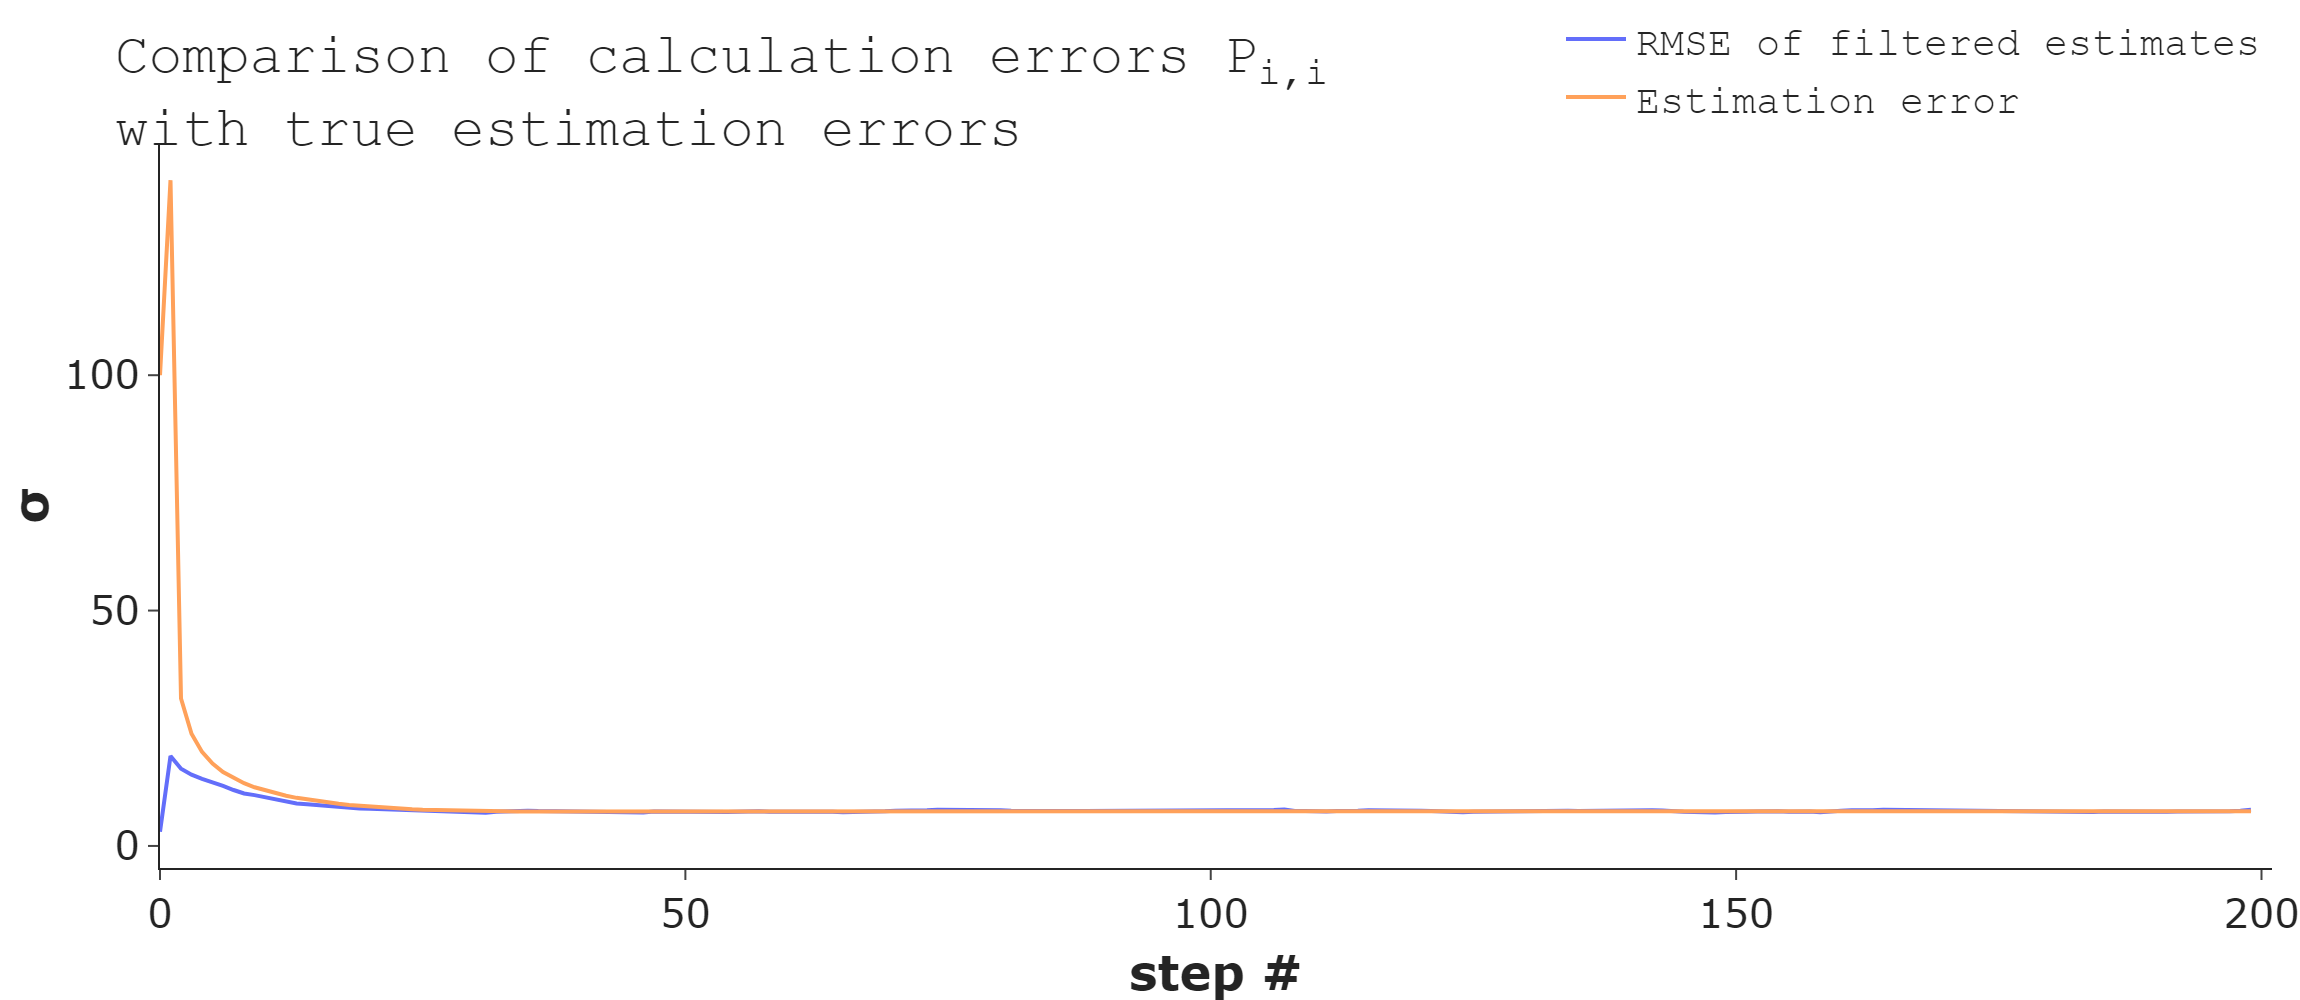

In [87]:
Image(f"Comparison of calculation errors with true estimation errors.png")

It is shown, that calculation errors of estimation correspond to true estimation errors

### Figure 9. Behaviour of filter gain, true estimation errors and calculation errors for deteministic trajectory

In [40]:
RMSE_true_filtered_0_var, RMSE_true_extrapol_0_var, K_gain_mean_0_var, P_diag_mean_0_var = final_error(M=500, P0_0_diag=10000, state_variance=0, Q_variance=0, X1=5, V1=1, K_determined=0, underestim_value=1, sample_size=200)

In [88]:
fig = go.Figure()

sample_size = 200
x = np.arange(sample_size)
y_fil_gain = K_gain_mean_0_var[0, :]
y_RMSE_true_pred = RMSE_true_filtered_0_var[0, :]
y_diag_mean = P_diag_mean_0_var[0, :]

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_fil_gain, 
                         name = 'Filter gain', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_pred, 
                         name = 'True estimation errors', 
                         line_color = colors[4]))

fig.add_trace(go.Scatter(x = x, y = y_diag_mean, 
                         name = 'Calculation errors', 
                         line_color = colors[8]))

fig.update_layout(template = 'simple_white', 
                  title = 'Filter behaviour for deterministic trajectory',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>\u03c3</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

In [89]:
fig.write_image(f"Comparison of calculation errors with true estimation errors.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

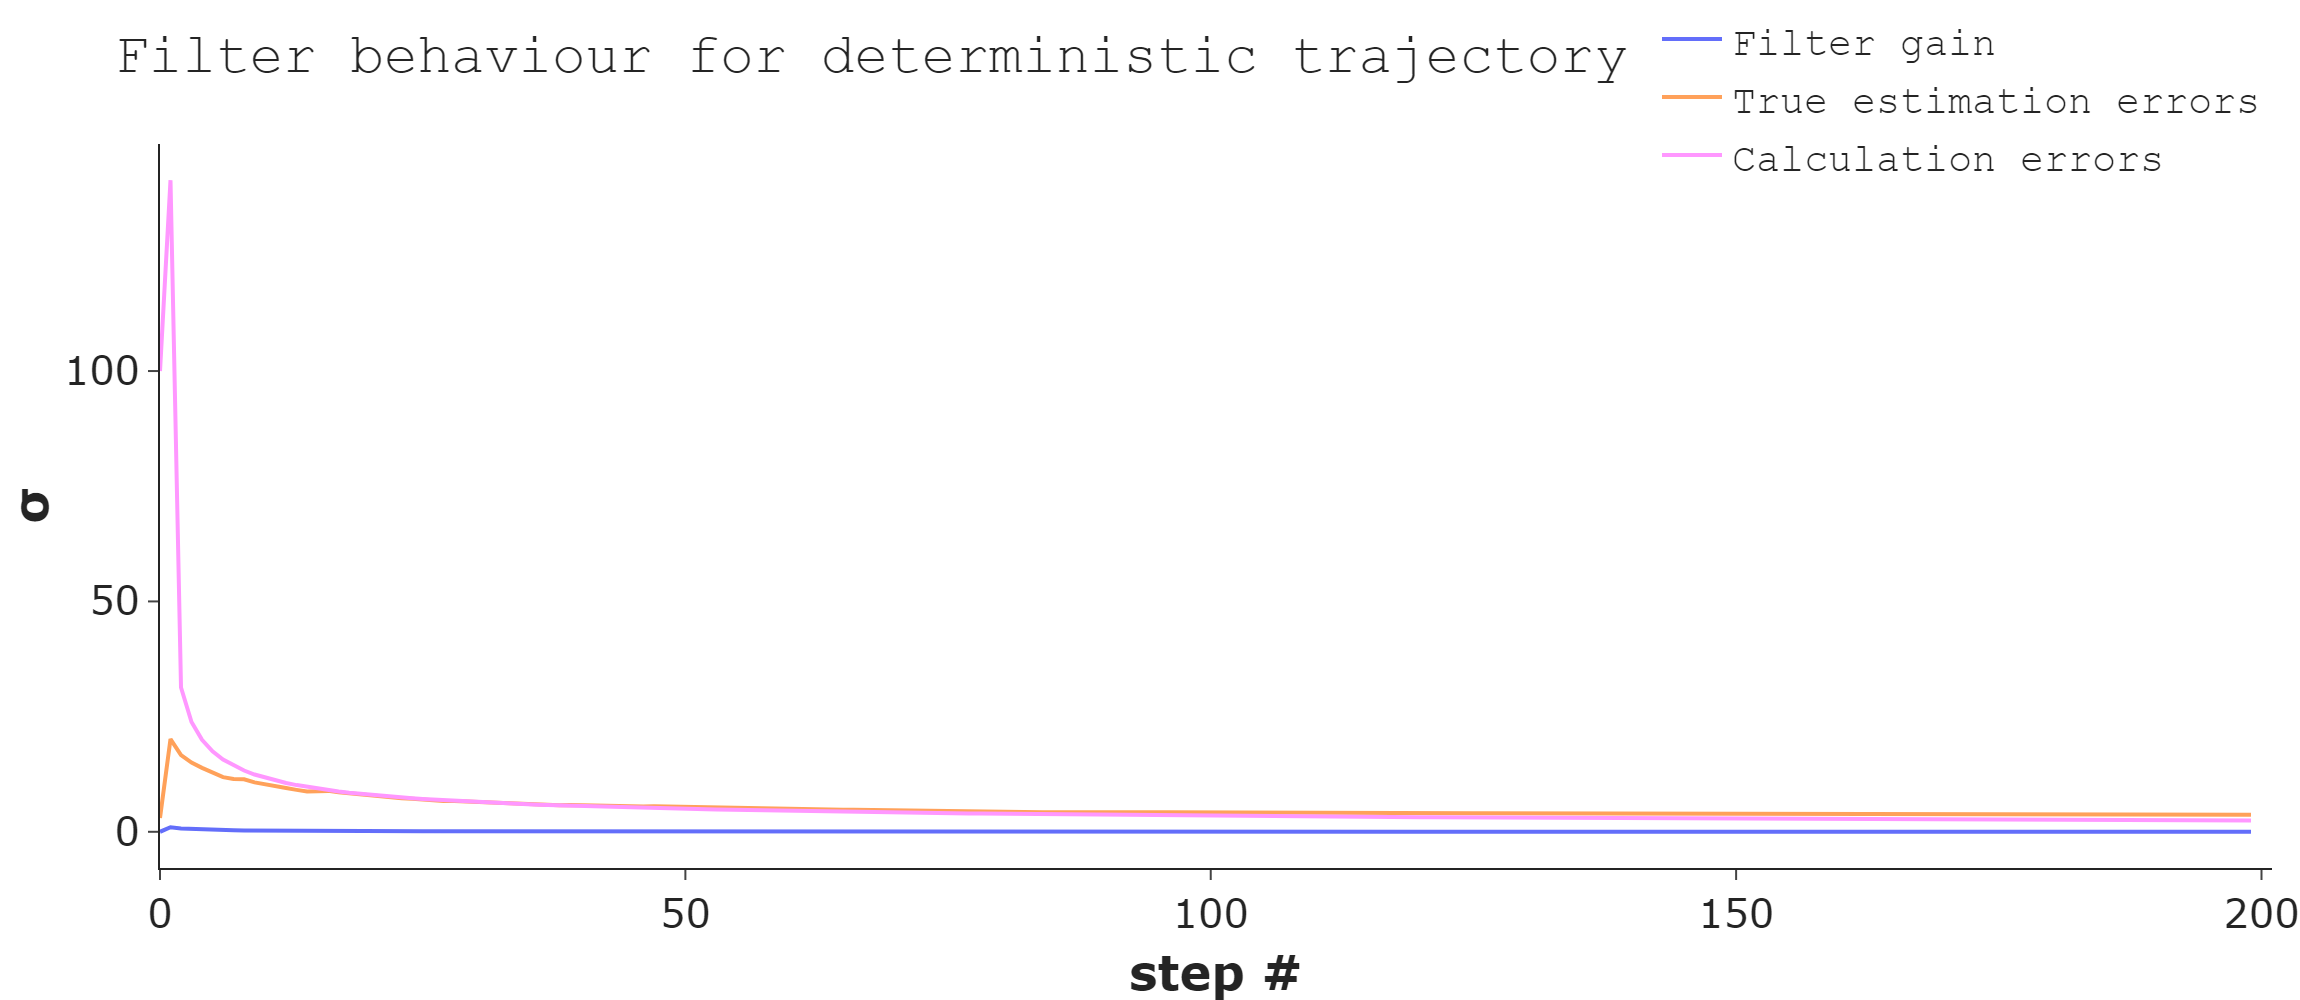

In [90]:
Image(f"Comparison of calculation errors with true estimation errors.png")

Filter gain, true estimation errors and calculations errors approaches to zero. This means that in conditions of motion without any random disturmances, estimation error approaches to zero and filter ignores measurements.

### Figure 10. Consequences of using Kalman filter for deteministic model

In [96]:
fig = go.Figure()

X_vector = state_equation(sample_size = 200, X1 = 5, V1 = 1, T = 1, variance = 0.2**2)
Z = measurement_equation(X=X_vector, meas_variance = 20**2)

X_filtered, K_gain, P_diag, X_extrapol = Kalman_filter(Z=Z, K_determined=0, underestim_value=1, sample_size=200, T=1, R=400, variance=0, m=7, P0_0_diag=10000)

sample_size = 200
x = np.arange(sample_size)
y_state_vec = X_vector[0, :]
y_meas = Z
y_kalman_filter = X_filtered[0, :]

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_state_vec, name = 'True trajectory', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = y_meas, name = 'Measurements', 
                         marker_color = colors[2], mode= 'markers', marker_size = 5))

fig.add_trace(go.Scatter(x = x, y = y_kalman_filter, 
                         name = 'Filtered estimates', 
                         line_color = colors[1]))

fig.update_layout(template = 'simple_white', 
                  title = 'Kalman filter for deterministic model',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>Object's X position</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

In [97]:
fig.write_image(f"Kalman filter for deteministic model.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

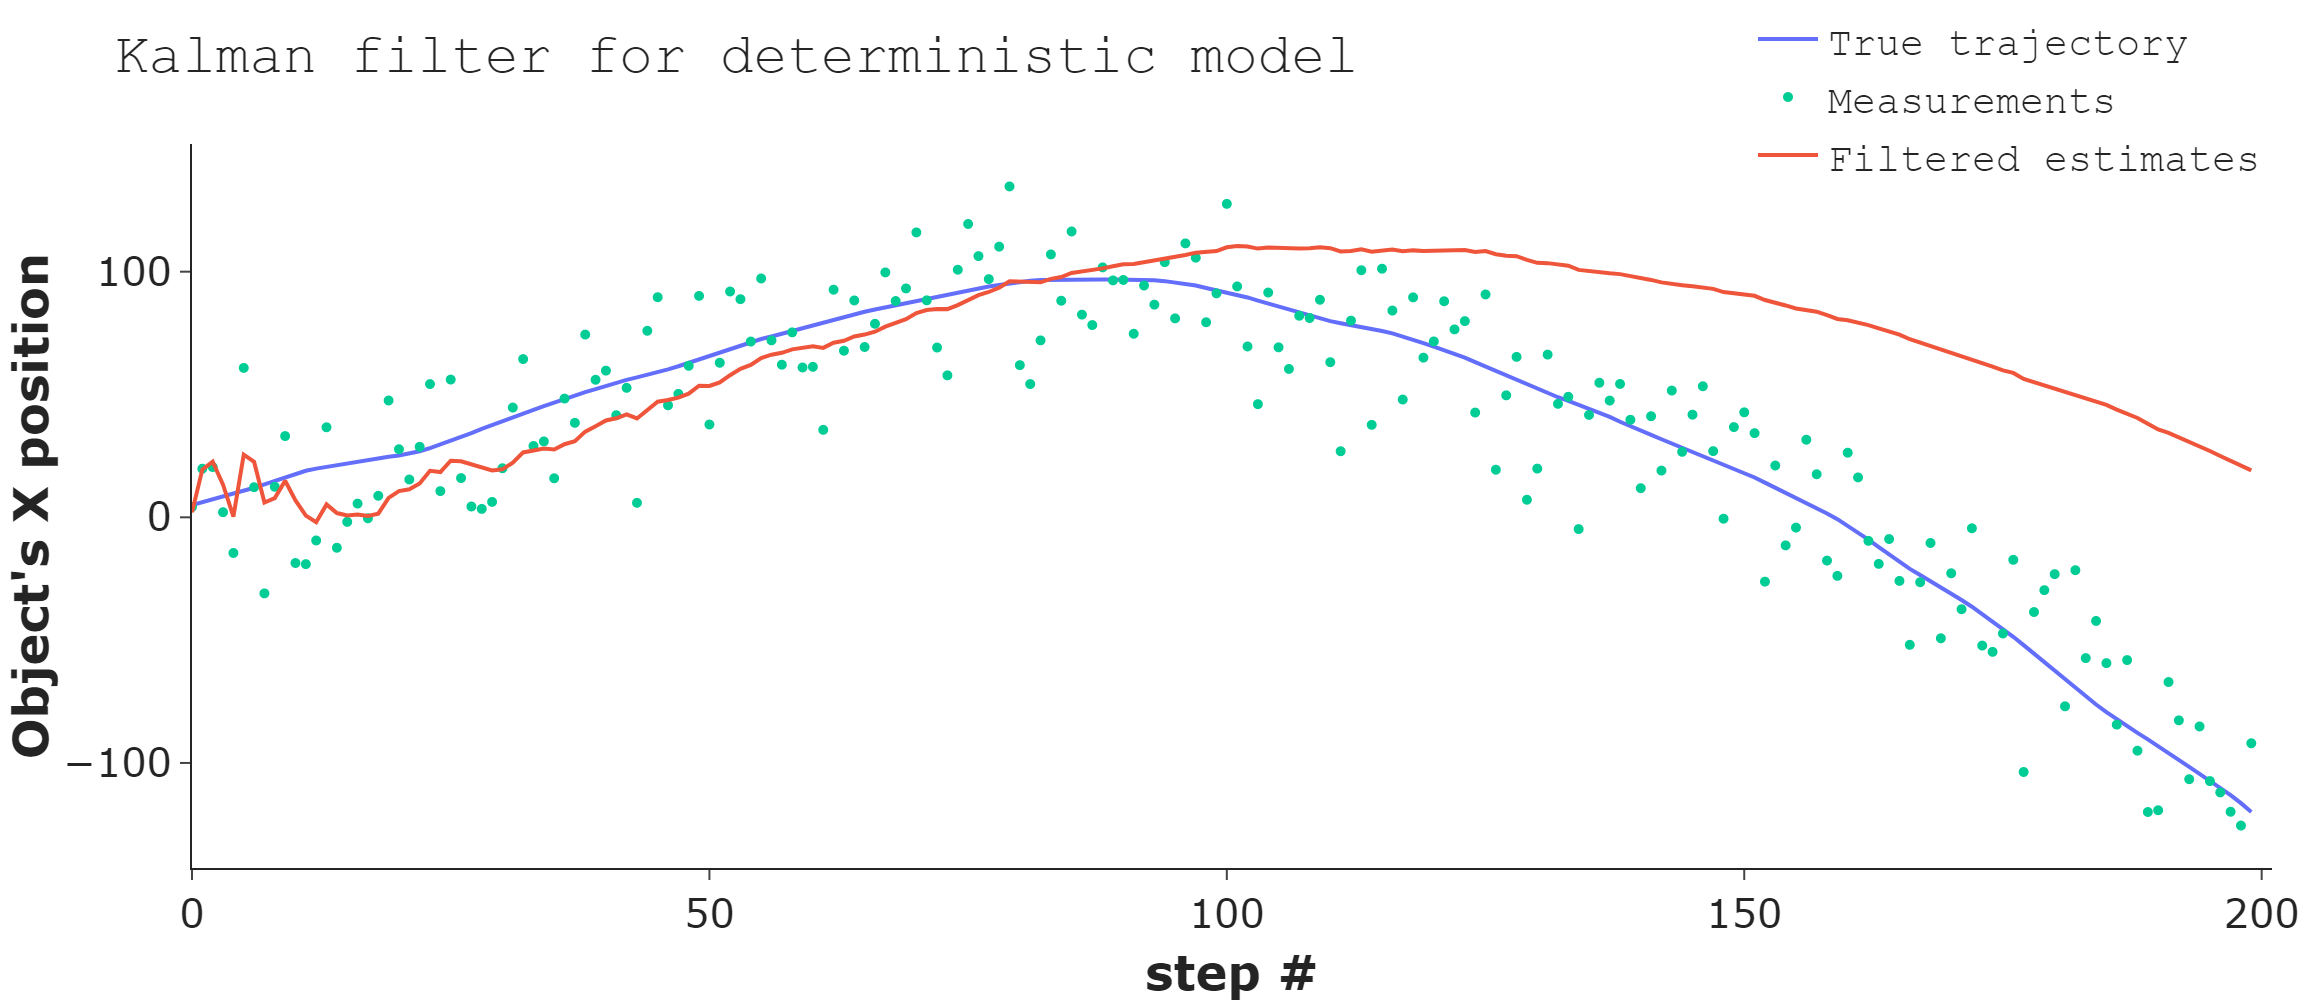

In [98]:
Image(f"Kalman filter for deteministic model.png")

It is noticed in Figure 10, that divergence of filtered estimates from true trajectory appears due to switching off Filter gain K.

### Figure 11. RMSE of filter dynamics for deterministic trajectory

In [99]:
fig = go.Figure()

RMSE_true_filtered, RMSE_true_extrapol, K_gain_mean, P_diag_mean = final_error(M=500, P0_0_diag=10000, state_variance=0.04, Q_variance=0, X1=5, V1=1, K_determined=0, underestim_value=1, sample_size=200)

sample_size = 200
x = np.arange(sample_size)
y_RMSE_true_filtered = RMSE_true_filtered[0, :]
y_RMSE_true_extrapol = RMSE_true_extrapol[0, :]

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_filtered, name = 'RMSE of FE with m=1', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_extrapol, name = 'RMSE of FE with m=7', 
                         line_color = colors[4]))

fig.update_layout(template = 'simple_white', 
                  title = 'RMSE of filter dynamics for<br> deterministic trajectory',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>\u03c3</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

In [100]:
fig.write_image(f"RMSE of filter dynamics for deterministic trajectory.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

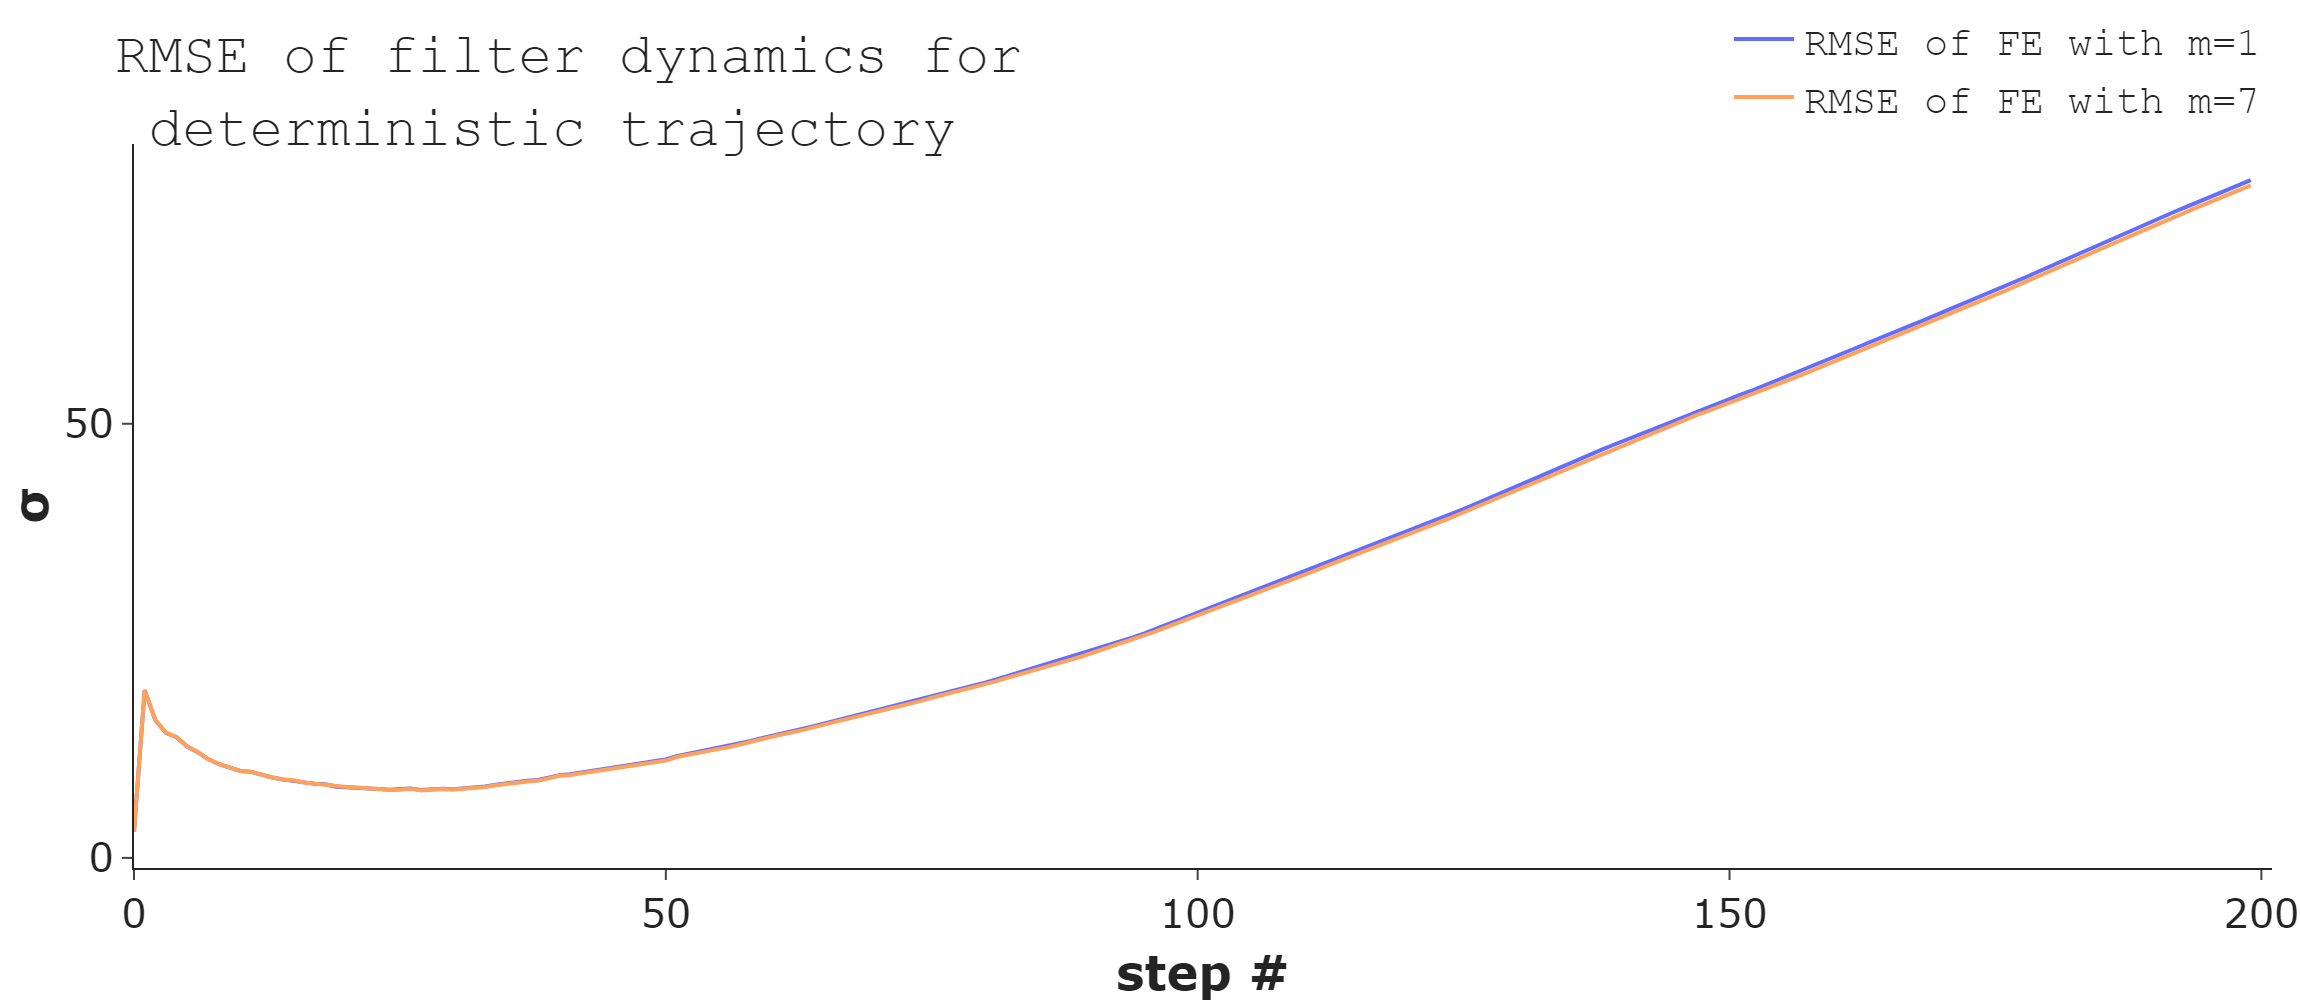

In [101]:
Image(f"RMSE of filter dynamics for deterministic trajectory.png")

Attempts to use Kalman filter with both extrapolation steps for deterministic model leads to divergence because, as it is known from Figure 9 and 10, Filter gain approaches to zero thereby Kalman filter stop properly working.

### Figure 12. Comparison of calculation errors with true estimation errors for deterministic model of motion

In [102]:
fig = go.Figure()

sample_size = 200
x = np.arange(sample_size)
y_RMSE_true_filtered = RMSE_true_filtered[0, :]
y_diag_mean = P_diag_mean[0, :]

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_filtered, 
                         name = 'True estimation errors', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = y_diag_mean, 
                         name = 'Calculation errors', 
                         line_color = colors[4]))

fig.update_layout(template = 'simple_white', 
                  title = 'Comparison of calculation errors P<sub>i,i</sub> <br>with true estimation errors',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>\u03c3</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

In [103]:
fig.write_image(f"Comparison of calculation errors with true estimation errors for deterministic model of motion.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

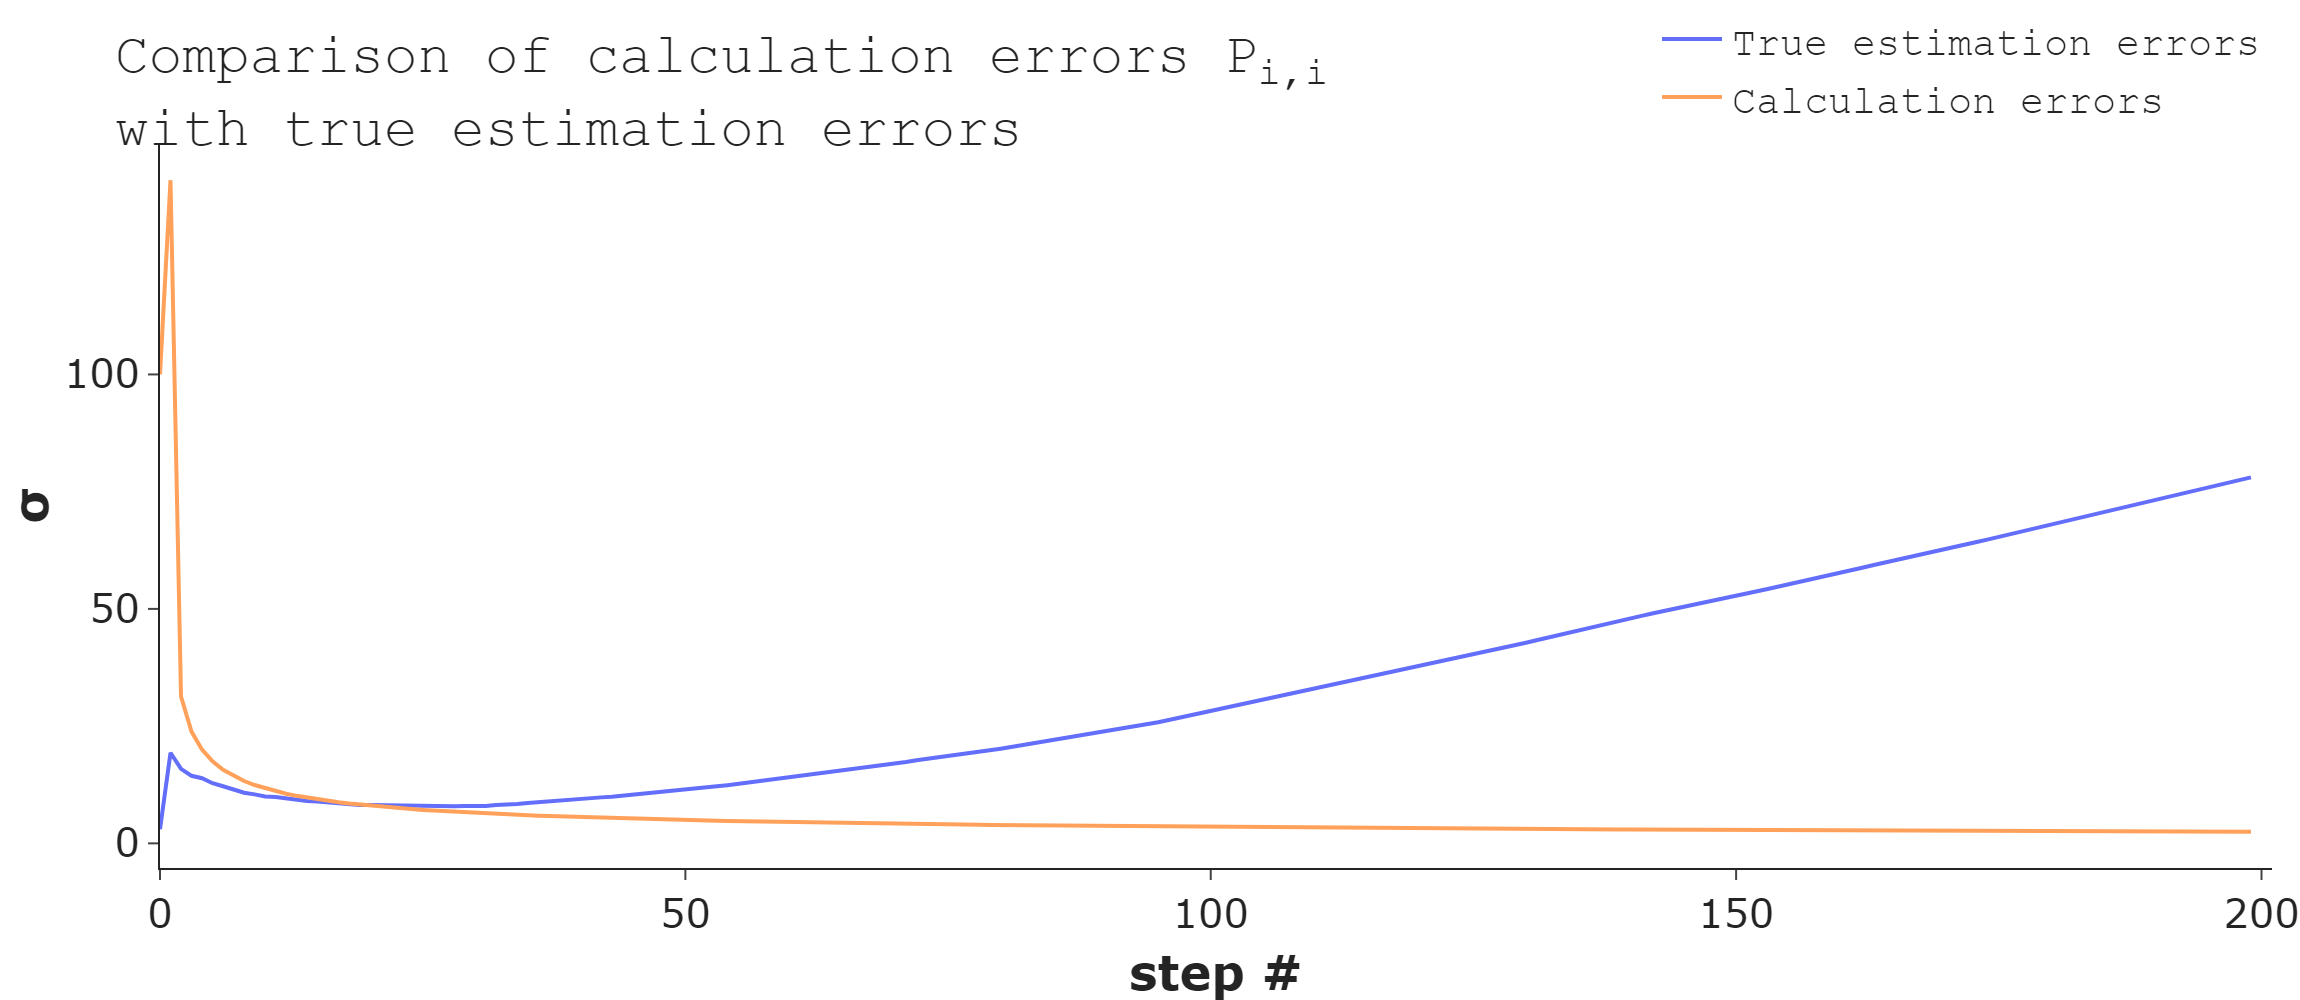

In [104]:
Image(f"Comparison of calculation errors with true estimation errors for deterministic model of motion.png")

It is verified in Figure 8, calculation errors of estimation correspond to true estimation errors, as Kalman filter is applied for non-deterministic model. In case of applying the filter for deterministic model of motion (but in fact motion is disturbed by random acceleration), leads to increasing of true estimation errors whereas calculation errors of estimation provided Kalman filter algorithm decrease and become almost constant. In this case, there is need to be careful to use Kalman filter in conditions of neglecting state noise.

### Figure 13. Comparison filter with different variance of state noise = $1^2$ and $0.2^2$ 

In [105]:
fig = go.Figure()

# Variance of state noise = 0.04
X_vector_var_004 = state_equation(sample_size = 200, X1 = 5, V1 = 1, T = 1, variance = 0.2**2)
Z_var_004 = measurement_equation(X=X_vector_var_004, meas_variance = 20**2)
X_filtered_var_004, K_gain_var_004, P_diag_var_004, X_extrapol_var_004 = Kalman_filter(Z=Z_var_004, K_determined=0, underestim_value=1, sample_size=200, T=1, R=400, variance=0.2**2, m=7, P0_0_diag=10000)

# Variance of state noise = 1
X_vector_var_1 = state_equation(sample_size = 200, X1 = 5, V1 = 1, T = 1, variance = 1**2)
Z_var_1 = measurement_equation(X=X_vector_var_1, meas_variance = 20**2)
X_filtered_var_1, K_gain_var_1, P_diag_var_1, X_extrapol_var_1 = Kalman_filter(Z=Z_var_1, K_determined=0, underestim_value=1, sample_size=200, T=1, R=400, variance=1**2, m=7, P0_0_diag=10000)

sample_size = 200
x = np.arange(sample_size)
y_K_004 = K_gain_var_004[0, :]
y_K_1 = K_gain_var_1[0, :]

y_kalman_P_diag_var_004 = P_diag_var_004[0, :] / 20
y_kalman_P_diag_var_1 = P_diag_var_1[0, :] / 20

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_K_004, name = 'Filter gain \u03C3<sup>2</sup><sub>a</sub>=0.2<sup>2</sup>', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = y_K_1, name = 'Filter gain \u03C3<sup>2</sup><sub>a</sub>=1<sup>2</sup>', 
                         line_color = colors[4]))

fig.add_trace(go.Scatter(x = x, y = y_kalman_P_diag_var_004, name = 'Calculation errors \u03C3<sup>2</sup><sub>a</sub>=0.2<sup>2</sup>', 
                         line_color = colors[6]))

fig.add_trace(go.Scatter(x = x, y = y_kalman_P_diag_var_1, name = 'Calculation errors \u03C3<sup>2</sup><sub>a</sub>=1<sup>2</sup>', 
                         line_color = colors[5]))

fig.update_layout(template = 'simple_white', 
                  title = 'Comparison filter with different variance <br>of state noise',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>\u03c3</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

In [106]:
fig.write_image(f"Comparison filter with different variance of state noise.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

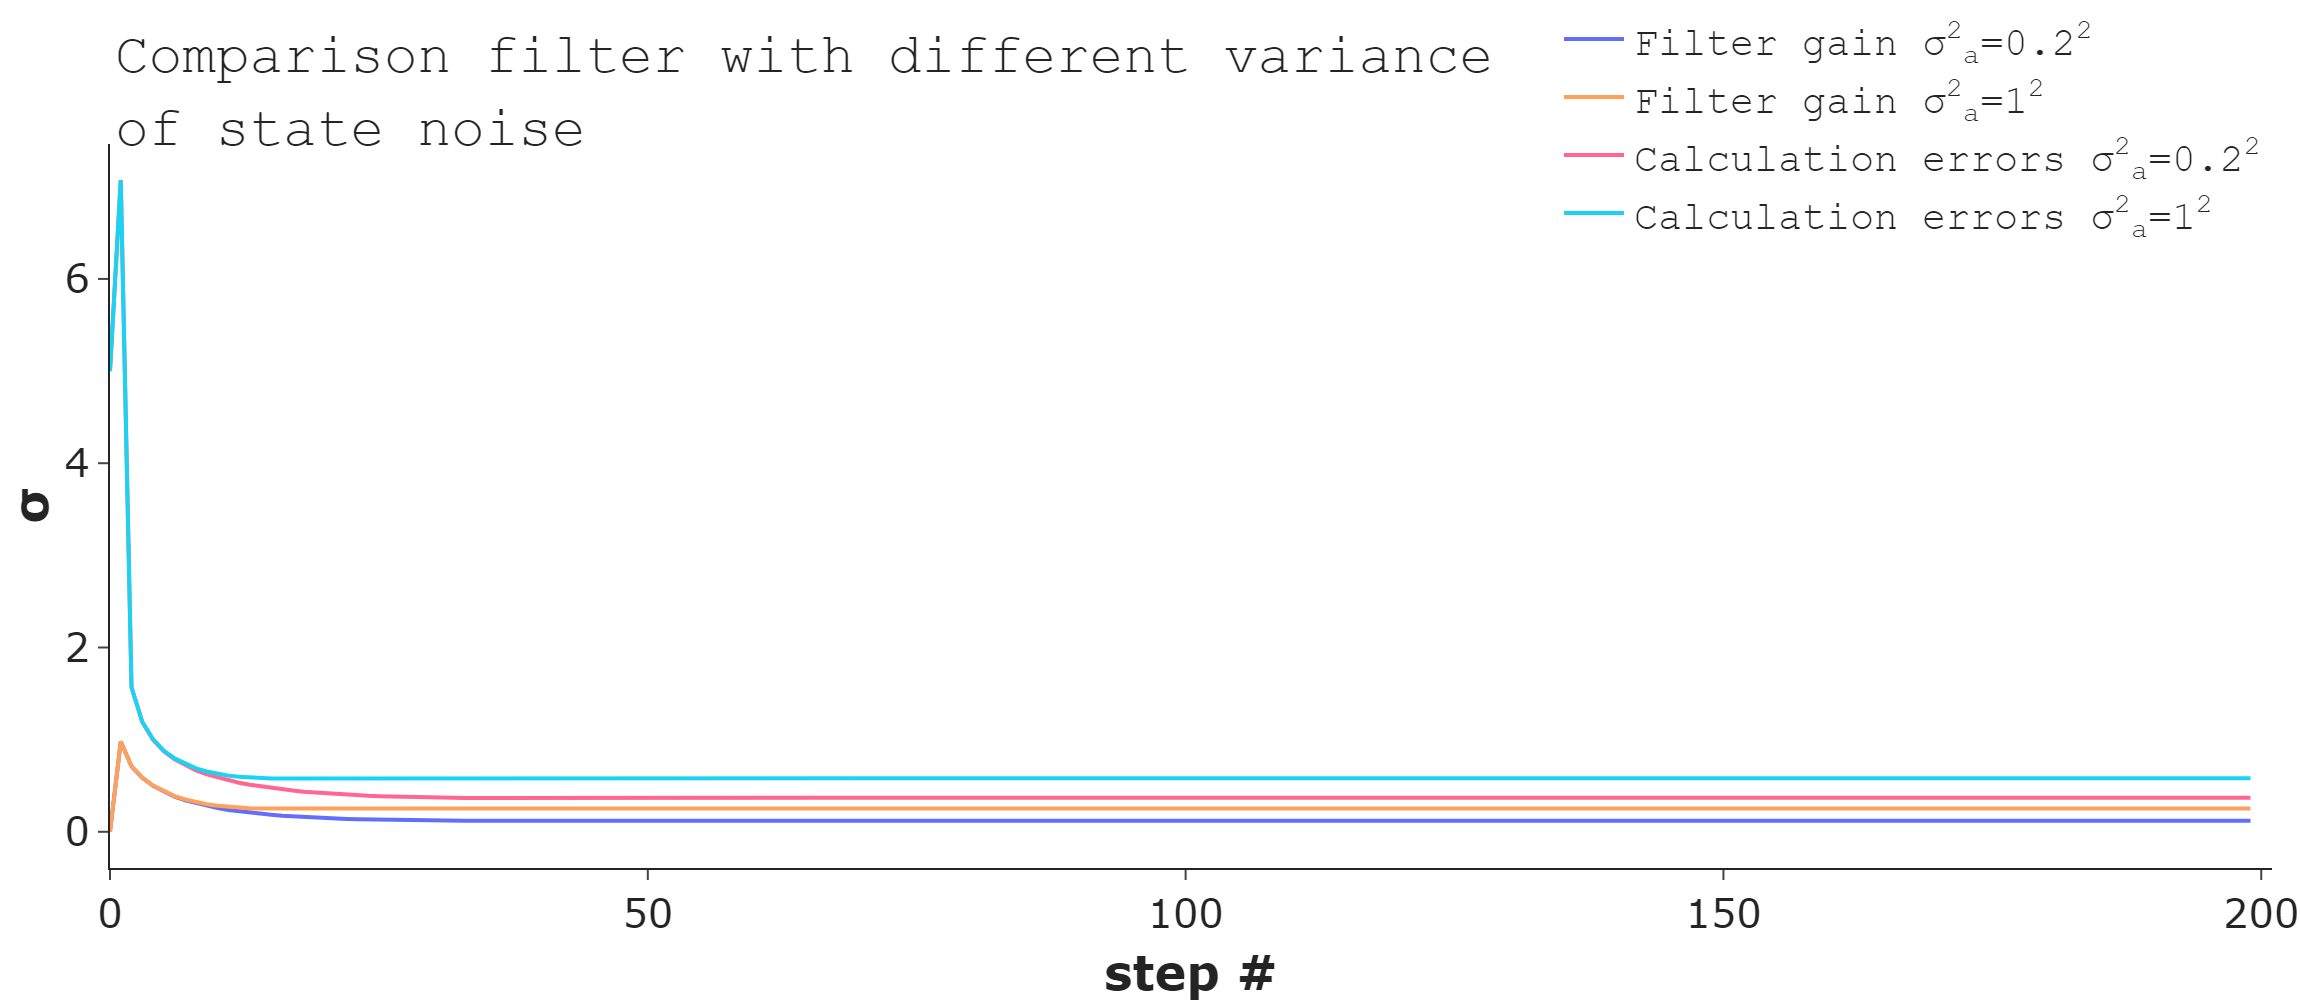

In [107]:
Image(f"Comparison filter with different variance of state noise.png")

Comparing filter with different variance of state noise, it is seen that increase of noise variance leads to increase of filter gain and calculation errors and shows the relations between them. The more noisy measurements, the less accurate filter will be.

### Figure 14. Analysis of filter sensitivity to underestimated non-optimal filter gain K

Calculate optimal filter gain and RMSE of filtered estimate of coordinate $x_{i,i}$ for M=500

In [56]:
RMSE_true_filtered, RMSE_true_extrapol, K_gain_mean, P_diag_mean = final_error(M=500, P0_0_diag=10000, state_variance=0.04, Q_variance=0.04, X1=5, V1=1, K_determined=0, underestim_value=1, sample_size=200)
K_gain_optimal = K_gain_mean[0, :].mean()
K_gain_optimal

0.1408335535117544

In [57]:
# RMSE of filtered estimate with optimal filter gain K
RMSE_true_filtered_K_opt, RMSE_true_extrapol_K_opt, K_gain_mean_K_opt, P_diag_mean_K_opt = final_error(P0_0_diag=10000, state_variance=0.2**2, Q_variance=0.2**2, X1=100, V1=5,  K_determined=K_gain_optimal, underestim_value=1, sample_size=200, M=500)

# RMSE of filtered estimate with underestimated filter gain K
RMSE_true_filtered_K_undest, RMSE_true_extrapol_K_undest, K_gain_mean_K_undest, P_diag_mean_K_undest = final_error(P0_0_diag=10000, state_variance=0.2**2, Q_variance=0.2**2, X1=100, V1=5, K_determined=K_gain_optimal, underestim_value=5, sample_size=200, M=500)


C:\Users\79179\AppData\Local\Temp\ipykernel_5916\180137221.py:59: RuntimeWarning:

invalid value encountered in sqrt



In [108]:
fig = go.Figure()

sample_size = 200
x = np.arange(sample_size)
y_RMSE_K_opt = RMSE_true_filtered_K_opt[0, :]
y_RMSE_K_undest = RMSE_true_filtered_K_undest[0, :]

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_RMSE_K_opt, name = 'RMSE with optimal K', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = y_RMSE_K_undest, 
                         name = 'RMSE with underestimated K', 
                         line_color = colors[1]))

fig.update_layout(template = 'simple_white', 
                  title = 'Analysis of filter sensitivity <br>to underestimated non-optimal filter gain',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>\u03c3</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

In [109]:
fig.write_image(f"Analysis of filter sensitivity to underestimated non-optimal filter gain.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

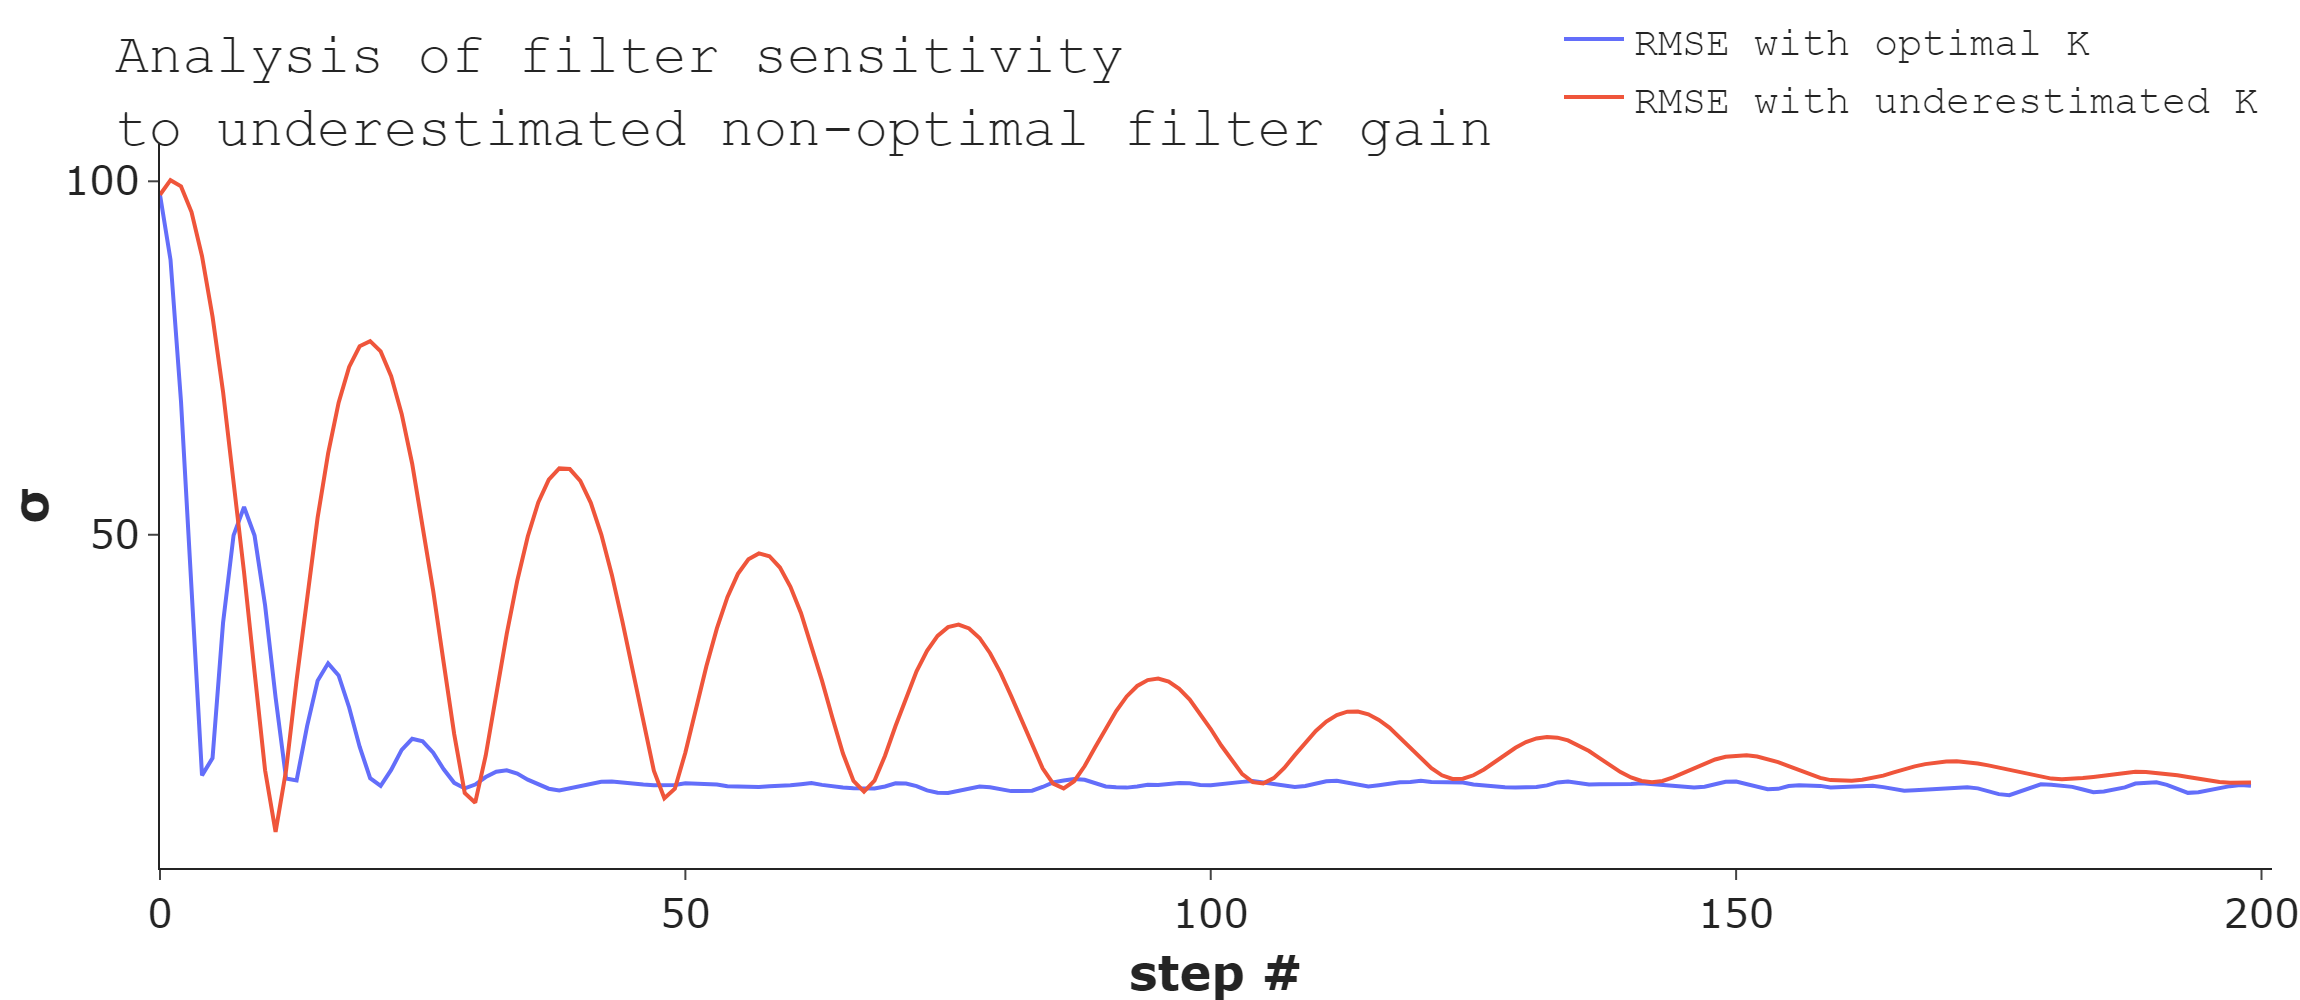

In [110]:
Image(f"Analysis of filter sensitivity to underestimated non-optimal filter gain.png")

Figure 14 shows that filter sensitivity decreases in conditions of non-optimal filter gain and more steps will be spent to come to constant estimation error.

## Conclusion

We have learned how to implement the standard Kalman filter algorithm for moving object tracking in conditions of random acceleration disturbed measurements. Filter gain and filtration error covariance stabilize after approximately 20 steps. This means that we quickly reach the accuracy limit defined by the state noise of the state-space model.

For large sample sizes initial conditions matrix $P_{0,0}$ does not affect estimation errors of Kalman filter in a significant way, although for small sample sizes the initial jump of estimation errors plays bigger role.

It is verified, that calculation errors of estimation correspond to true estimation errors, as Kalman filter is applied for non-deterministic model. In case of applying the filter for deterministic model of motion (but in fact motion is disturbed by random acceleration), true estimation errors increase, whereas calculation errors of estimation provided by Kalman filter algorithm decrease asymptotically to a constant value. Hence we need to be careful in order not to neglect state noise, while using Kalman filter.

Comparing filter with different variance of state noise, we observe the increase of noise variance with the increase of both filter gain and calculation errors, which suggests correlation between them. The more noisy the measurements are, the less accurate the filter will be. Filter sensitivity decreases in conditions of non-optimal filter gain, hence more steps will be needed to reach stable values of estimation error.